In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_e_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4014968, 919)
(4014968, 8)
validation
(782336, 919)
(782336, 8)
test
(325224, 919)
(325224, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1632136 (6.23 MB)


Trainable params: 1632136 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/402 [..............................] - ETA: 8:30 - loss: 2.3694 - STD: 0.1023 - MAE: 0.2196

  4/402 [..............................] - ETA: 7s - loss: 2.1657 - STD: 0.0607 - MAE: 0.2175  

  7/402 [..............................] - ETA: 7s - loss: 2.1307 - STD: 0.0570 - MAE: 0.2168

 10/402 [..............................] - ETA: 7s - loss: 2.1201 - STD: 0.0537 - MAE: 0.2168

 13/402 [..............................] - ETA: 6s - loss: 2.1083 - STD: 0.0502 - MAE: 0.2168

 16/402 [>.............................] - ETA: 6s - loss: 2.0982 - STD: 0.0471 - MAE: 0.2168

 19/402 [>.............................] - ETA: 6s - loss: 2.0916 - STD: 0.0448 - MAE: 0.2168

 22/402 [>.............................] - ETA: 6s - loss: 2.0867 - STD: 0.0432 - MAE: 0.2168

 25/402 [>.............................] - ETA: 6s - loss: 2.0827 - STD: 0.0417 - MAE: 0.2168

 28/402 [=>............................] - ETA: 6s - loss: 2.0788 - STD: 0.0404 - MAE: 0.2168

 31/402 [=>............................] - ETA: 6s - loss: 2.0753 - STD: 0.0396 - MAE: 0.2167

 34/402 [=>............................] - ETA: 6s - loss: 2.0717 - STD: 0.0392 - MAE: 0.2167

 37/402 [=>............................] - ETA: 6s - loss: 2.0683 - STD: 0.0389 - MAE: 0.2166

 40/402 [=>............................] - ETA: 6s - loss: 2.0640 - STD: 0.0386 - MAE: 0.2165

 43/402 [==>...........................] - ETA: 6s - loss: 2.0588 - STD: 0.0386 - MAE: 0.2163

 46/402 [==>...........................] - ETA: 6s - loss: 2.0530 - STD: 0.0388 - MAE: 0.2161

 49/402 [==>...........................] - ETA: 6s - loss: 2.0464 - STD: 0.0394 - MAE: 0.2159

 52/402 [==>...........................] - ETA: 6s - loss: 2.0395 - STD: 0.0404 - MAE: 0.2156

 55/402 [===>..........................] - ETA: 6s - loss: 2.0315 - STD: 0.0417 - MAE: 0.2152

 58/402 [===>..........................] - ETA: 6s - loss: 2.0226 - STD: 0.0430 - MAE: 0.2148

 61/402 [===>..........................] - ETA: 6s - loss: 2.0131 - STD: 0.0443 - MAE: 0.2144

 64/402 [===>..........................] - ETA: 6s - loss: 2.0028 - STD: 0.0457 - MAE: 0.2140

 67/402 [====>.........................] - ETA: 5s - loss: 1.9920 - STD: 0.0472 - MAE: 0.2135

 70/402 [====>.........................] - ETA: 5s - loss: 1.9804 - STD: 0.0487 - MAE: 0.2129

 73/402 [====>.........................] - ETA: 5s - loss: 1.9683 - STD: 0.0503 - MAE: 0.2123

 76/402 [====>.........................] - ETA: 5s - loss: 1.9559 - STD: 0.0521 - MAE: 0.2117

 79/402 [====>.........................] - ETA: 5s - loss: 1.9434 - STD: 0.0540 - MAE: 0.2110

 82/402 [=====>........................] - ETA: 5s - loss: 1.9309 - STD: 0.0560 - MAE: 0.2103

 85/402 [=====>........................] - ETA: 5s - loss: 1.9187 - STD: 0.0580 - MAE: 0.2095

 88/402 [=====>........................] - ETA: 5s - loss: 1.9068 - STD: 0.0601 - MAE: 0.2088

 91/402 [=====>........................] - ETA: 5s - loss: 1.8950 - STD: 0.0621 - MAE: 0.2080

 94/402 [======>.......................] - ETA: 5s - loss: 1.8837 - STD: 0.0641 - MAE: 0.2073

 97/402 [======>.......................] - ETA: 5s - loss: 1.8724 - STD: 0.0660 - MAE: 0.2066

100/402 [======>.......................] - ETA: 5s - loss: 1.8616 - STD: 0.0678 - MAE: 0.2059

103/402 [======>.......................] - ETA: 5s - loss: 1.8508 - STD: 0.0695 - MAE: 0.2052

106/402 [======>.......................] - ETA: 5s - loss: 1.8406 - STD: 0.0713 - MAE: 0.2045

109/402 [=======>......................] - ETA: 5s - loss: 1.8303 - STD: 0.0730 - MAE: 0.2038

112/402 [=======>......................] - ETA: 5s - loss: 1.8205 - STD: 0.0747 - MAE: 0.2031

115/402 [=======>......................] - ETA: 5s - loss: 1.8106 - STD: 0.0763 - MAE: 0.2024

118/402 [=======>......................] - ETA: 4s - loss: 1.8008 - STD: 0.0780 - MAE: 0.2017

121/402 [========>.....................] - ETA: 4s - loss: 1.7915 - STD: 0.0795 - MAE: 0.2011

124/402 [========>.....................] - ETA: 4s - loss: 1.7824 - STD: 0.0811 - MAE: 0.2004

127/402 [========>.....................] - ETA: 4s - loss: 1.7734 - STD: 0.0826 - MAE: 0.1998

130/402 [========>.....................] - ETA: 4s - loss: 1.7648 - STD: 0.0841 - MAE: 0.1992

133/402 [========>.....................] - ETA: 4s - loss: 1.7563 - STD: 0.0855 - MAE: 0.1986

136/402 [=========>....................] - ETA: 4s - loss: 1.7482 - STD: 0.0869 - MAE: 0.1980

139/402 [=========>....................] - ETA: 4s - loss: 1.7401 - STD: 0.0883 - MAE: 0.1974

142/402 [=========>....................] - ETA: 4s - loss: 1.7323 - STD: 0.0896 - MAE: 0.1968

145/402 [=========>....................] - ETA: 4s - loss: 1.7243 - STD: 0.0909 - MAE: 0.1962

148/402 [==========>...................] - ETA: 4s - loss: 1.7169 - STD: 0.0922 - MAE: 0.1956

151/402 [==========>...................] - ETA: 4s - loss: 1.7094 - STD: 0.0935 - MAE: 0.1951

154/402 [==========>...................] - ETA: 4s - loss: 1.7022 - STD: 0.0947 - MAE: 0.1945

157/402 [==========>...................] - ETA: 4s - loss: 1.6954 - STD: 0.0959 - MAE: 0.1940

160/402 [==========>...................] - ETA: 4s - loss: 1.6884 - STD: 0.0971 - MAE: 0.1935

163/402 [===========>..................] - ETA: 4s - loss: 1.6818 - STD: 0.0982 - MAE: 0.1930

166/402 [===========>..................] - ETA: 4s - loss: 1.6752 - STD: 0.0993 - MAE: 0.1925

169/402 [===========>..................] - ETA: 4s - loss: 1.6689 - STD: 0.1004 - MAE: 0.1920

172/402 [===========>..................] - ETA: 4s - loss: 1.6628 - STD: 0.1014 - MAE: 0.1915

175/402 [============>.................] - ETA: 3s - loss: 1.6567 - STD: 0.1025 - MAE: 0.1910

178/402 [============>.................] - ETA: 3s - loss: 1.6508 - STD: 0.1035 - MAE: 0.1906

181/402 [============>.................] - ETA: 3s - loss: 1.6448 - STD: 0.1045 - MAE: 0.1901

184/402 [============>.................] - ETA: 3s - loss: 1.6391 - STD: 0.1054 - MAE: 0.1896

187/402 [============>.................] - ETA: 3s - loss: 1.6334 - STD: 0.1064 - MAE: 0.1892

190/402 [=============>................] - ETA: 3s - loss: 1.6278 - STD: 0.1073 - MAE: 0.1888

193/402 [=============>................] - ETA: 3s - loss: 1.6224 - STD: 0.1082 - MAE: 0.1883

196/402 [=============>................] - ETA: 3s - loss: 1.6172 - STD: 0.1091 - MAE: 0.1879

199/402 [=============>................] - ETA: 3s - loss: 1.6121 - STD: 0.1100 - MAE: 0.1875

202/402 [==============>...............] - ETA: 3s - loss: 1.6072 - STD: 0.1108 - MAE: 0.1871

205/402 [==============>...............] - ETA: 3s - loss: 1.6028 - STD: 0.1116 - MAE: 0.1868

208/402 [==============>...............] - ETA: 3s - loss: 1.5982 - STD: 0.1125 - MAE: 0.1864

211/402 [==============>...............] - ETA: 3s - loss: 1.5936 - STD: 0.1133 - MAE: 0.1860

214/402 [==============>...............] - ETA: 3s - loss: 1.5893 - STD: 0.1141 - MAE: 0.1857

217/402 [===============>..............] - ETA: 3s - loss: 1.5847 - STD: 0.1148 - MAE: 0.1853

220/402 [===============>..............] - ETA: 3s - loss: 1.5802 - STD: 0.1155 - MAE: 0.1849

223/402 [===============>..............] - ETA: 3s - loss: 1.5758 - STD: 0.1163 - MAE: 0.1846

226/402 [===============>..............] - ETA: 3s - loss: 1.5716 - STD: 0.1170 - MAE: 0.1842

229/402 [================>.............] - ETA: 3s - loss: 1.5672 - STD: 0.1177 - MAE: 0.1839

232/402 [================>.............] - ETA: 2s - loss: 1.5629 - STD: 0.1184 - MAE: 0.1836

235/402 [================>.............] - ETA: 2s - loss: 1.5589 - STD: 0.1191 - MAE: 0.1832

238/402 [================>.............] - ETA: 2s - loss: 1.5548 - STD: 0.1197 - MAE: 0.1829

241/402 [================>.............] - ETA: 2s - loss: 1.5508 - STD: 0.1204 - MAE: 0.1826

244/402 [=================>............] - ETA: 2s - loss: 1.5470 - STD: 0.1210 - MAE: 0.1823

247/402 [=================>............] - ETA: 2s - loss: 1.5430 - STD: 0.1217 - MAE: 0.1819

250/402 [=================>............] - ETA: 2s - loss: 1.5392 - STD: 0.1223 - MAE: 0.1816

253/402 [=================>............] - ETA: 2s - loss: 1.5355 - STD: 0.1229 - MAE: 0.1813

256/402 [==================>...........] - ETA: 2s - loss: 1.5324 - STD: 0.1235 - MAE: 0.1811

259/402 [==================>...........] - ETA: 2s - loss: 1.5292 - STD: 0.1241 - MAE: 0.1808

262/402 [==================>...........] - ETA: 2s - loss: 1.5258 - STD: 0.1247 - MAE: 0.1805

265/402 [==================>...........] - ETA: 2s - loss: 1.5224 - STD: 0.1253 - MAE: 0.1802

268/402 [===================>..........] - ETA: 2s - loss: 1.5190 - STD: 0.1259 - MAE: 0.1799

271/402 [===================>..........] - ETA: 2s - loss: 1.5157 - STD: 0.1264 - MAE: 0.1797

274/402 [===================>..........] - ETA: 2s - loss: 1.5124 - STD: 0.1269 - MAE: 0.1794

277/402 [===================>..........] - ETA: 2s - loss: 1.5090 - STD: 0.1275 - MAE: 0.1791

280/402 [===================>..........] - ETA: 2s - loss: 1.5058 - STD: 0.1280 - MAE: 0.1788

283/402 [====================>.........] - ETA: 2s - loss: 1.5026 - STD: 0.1285 - MAE: 0.1786

286/402 [====================>.........] - ETA: 2s - loss: 1.4994 - STD: 0.1290 - MAE: 0.1783

289/402 [====================>.........] - ETA: 1s - loss: 1.4962 - STD: 0.1295 - MAE: 0.1780

292/402 [====================>.........] - ETA: 1s - loss: 1.4932 - STD: 0.1300 - MAE: 0.1778

295/402 [=====================>........] - ETA: 1s - loss: 1.4902 - STD: 0.1305 - MAE: 0.1775

298/402 [=====================>........] - ETA: 1s - loss: 1.4872 - STD: 0.1310 - MAE: 0.1773

301/402 [=====================>........] - ETA: 1s - loss: 1.4842 - STD: 0.1315 - MAE: 0.1771

304/402 [=====================>........] - ETA: 1s - loss: 1.4813 - STD: 0.1320 - MAE: 0.1768

307/402 [=====================>........] - ETA: 1s - loss: 1.4784 - STD: 0.1324 - MAE: 0.1766

310/402 [======================>.......] - ETA: 1s - loss: 1.4755 - STD: 0.1329 - MAE: 0.1763

313/402 [======================>.......] - ETA: 1s - loss: 1.4728 - STD: 0.1334 - MAE: 0.1761

316/402 [======================>.......] - ETA: 1s - loss: 1.4701 - STD: 0.1338 - MAE: 0.1759

319/402 [======================>.......] - ETA: 1s - loss: 1.4673 - STD: 0.1343 - MAE: 0.1756

322/402 [=======================>......] - ETA: 1s - loss: 1.4647 - STD: 0.1347 - MAE: 0.1754

325/402 [=======================>......] - ETA: 1s - loss: 1.4620 - STD: 0.1351 - MAE: 0.1752

328/402 [=======================>......] - ETA: 1s - loss: 1.4594 - STD: 0.1356 - MAE: 0.1749

331/402 [=======================>......] - ETA: 1s - loss: 1.4571 - STD: 0.1360 - MAE: 0.1747

334/402 [=======================>......] - ETA: 1s - loss: 1.4550 - STD: 0.1364 - MAE: 0.1745

337/402 [========================>.....] - ETA: 1s - loss: 1.4526 - STD: 0.1368 - MAE: 0.1743

340/402 [========================>.....] - ETA: 1s - loss: 1.4502 - STD: 0.1372 - MAE: 0.1741

343/402 [========================>.....] - ETA: 1s - loss: 1.4478 - STD: 0.1376 - MAE: 0.1739

346/402 [========================>.....] - ETA: 0s - loss: 1.4454 - STD: 0.1380 - MAE: 0.1737

349/402 [=========================>....] - ETA: 0s - loss: 1.4429 - STD: 0.1384 - MAE: 0.1735

352/402 [=========================>....] - ETA: 0s - loss: 1.4404 - STD: 0.1388 - MAE: 0.1733

355/402 [=========================>....] - ETA: 0s - loss: 1.4382 - STD: 0.1391 - MAE: 0.1731

358/402 [=========================>....] - ETA: 0s - loss: 1.4359 - STD: 0.1395 - MAE: 0.1729

361/402 [=========================>....] - ETA: 0s - loss: 1.4335 - STD: 0.1399 - MAE: 0.1727

364/402 [==========================>...] - ETA: 0s - loss: 1.4313 - STD: 0.1403 - MAE: 0.1725

367/402 [==========================>...] - ETA: 0s - loss: 1.4291 - STD: 0.1406 - MAE: 0.1723

370/402 [==========================>...] - ETA: 0s - loss: 1.4272 - STD: 0.1410 - MAE: 0.1721

374/402 [==========================>...] - ETA: 0s - loss: 1.4243 - STD: 0.1414 - MAE: 0.1719

377/402 [===========================>..] - ETA: 0s - loss: 1.4221 - STD: 0.1418 - MAE: 0.1717

380/402 [===========================>..] - ETA: 0s - loss: 1.4198 - STD: 0.1421 - MAE: 0.1715

383/402 [===========================>..] - ETA: 0s - loss: 1.4177 - STD: 0.1425 - MAE: 0.1713

386/402 [===========================>..] - ETA: 0s - loss: 1.4160 - STD: 0.1428 - MAE: 0.1711

389/402 [============================>.] - ETA: 0s - loss: 1.4141 - STD: 0.1431 - MAE: 0.1710

392/402 [============================>.] - ETA: 0s - loss: 1.4122 - STD: 0.1435 - MAE: 0.1708

395/402 [============================>.] - ETA: 0s - loss: 1.4103 - STD: 0.1438 - MAE: 0.1706

398/402 [============================>.] - ETA: 0s - loss: 1.4084 - STD: 0.1441 - MAE: 0.1705

402/402 [==============================] - ETA: 0s - loss: 1.4058 - STD: 0.1445 - MAE: 0.1702

402/402 [==============================] - 11s 24ms/step - loss: 1.4058 - STD: 0.1445 - MAE: 0.1702 - val_loss: 1.2918 - val_STD: 0.1825 - val_MAE: 0.1566


Epoch 2/10000


  1/402 [..............................] - ETA: 17s - loss: 1.1575 - STD: 0.1892 - MAE: 0.1470

  4/402 [..............................] - ETA: 6s - loss: 1.1429 - STD: 0.1870 - MAE: 0.1472 

  7/402 [..............................] - ETA: 6s - loss: 1.1383 - STD: 0.1863 - MAE: 0.1472

 10/402 [..............................] - ETA: 6s - loss: 1.1372 - STD: 0.1863 - MAE: 0.1471

 13/402 [..............................] - ETA: 6s - loss: 1.1344 - STD: 0.1867 - MAE: 0.1468

 16/402 [>.............................] - ETA: 6s - loss: 1.1323 - STD: 0.1868 - MAE: 0.1467

 19/402 [>.............................] - ETA: 6s - loss: 1.1296 - STD: 0.1870 - MAE: 0.1465

 22/402 [>.............................] - ETA: 6s - loss: 1.1296 - STD: 0.1872 - MAE: 0.1464

 25/402 [>.............................] - ETA: 6s - loss: 1.1294 - STD: 0.1873 - MAE: 0.1464

 28/402 [=>............................] - ETA: 6s - loss: 1.1286 - STD: 0.1875 - MAE: 0.1463

 31/402 [=>............................] - ETA: 6s - loss: 1.1277 - STD: 0.1876 - MAE: 0.1462

 34/402 [=>............................] - ETA: 6s - loss: 1.1268 - STD: 0.1876 - MAE: 0.1461

 37/402 [=>............................] - ETA: 6s - loss: 1.1259 - STD: 0.1878 - MAE: 0.1460

 40/402 [=>............................] - ETA: 6s - loss: 1.1274 - STD: 0.1878 - MAE: 0.1461

 43/402 [==>...........................] - ETA: 6s - loss: 1.1271 - STD: 0.1879 - MAE: 0.1460

 47/402 [==>...........................] - ETA: 6s - loss: 1.1276 - STD: 0.1881 - MAE: 0.1459

 51/402 [==>...........................] - ETA: 6s - loss: 1.1290 - STD: 0.1882 - MAE: 0.1460

 55/402 [===>..........................] - ETA: 5s - loss: 1.1297 - STD: 0.1883 - MAE: 0.1460

 58/402 [===>..........................] - ETA: 5s - loss: 1.1302 - STD: 0.1883 - MAE: 0.1460

 61/402 [===>..........................] - ETA: 5s - loss: 1.1298 - STD: 0.1884 - MAE: 0.1459

 64/402 [===>..........................] - ETA: 5s - loss: 1.1286 - STD: 0.1885 - MAE: 0.1458

 67/402 [====>.........................] - ETA: 5s - loss: 1.1276 - STD: 0.1886 - MAE: 0.1457

 70/402 [====>.........................] - ETA: 5s - loss: 1.1263 - STD: 0.1887 - MAE: 0.1456

 73/402 [====>.........................] - ETA: 5s - loss: 1.1256 - STD: 0.1888 - MAE: 0.1456

 76/402 [====>.........................] - ETA: 5s - loss: 1.1254 - STD: 0.1889 - MAE: 0.1455

 79/402 [====>.........................] - ETA: 5s - loss: 1.1244 - STD: 0.1890 - MAE: 0.1454

 82/402 [=====>........................] - ETA: 5s - loss: 1.1236 - STD: 0.1891 - MAE: 0.1454

 85/402 [=====>........................] - ETA: 5s - loss: 1.1225 - STD: 0.1891 - MAE: 0.1453

 88/402 [=====>........................] - ETA: 5s - loss: 1.1215 - STD: 0.1892 - MAE: 0.1452

 92/402 [=====>........................] - ETA: 5s - loss: 1.1201 - STD: 0.1894 - MAE: 0.1451

 95/402 [======>.......................] - ETA: 5s - loss: 1.1199 - STD: 0.1895 - MAE: 0.1450

 98/402 [======>.......................] - ETA: 5s - loss: 1.1204 - STD: 0.1896 - MAE: 0.1450

101/402 [======>.......................] - ETA: 5s - loss: 1.1197 - STD: 0.1897 - MAE: 0.1449

104/402 [======>.......................] - ETA: 5s - loss: 1.1189 - STD: 0.1898 - MAE: 0.1449

107/402 [======>.......................] - ETA: 5s - loss: 1.1186 - STD: 0.1898 - MAE: 0.1448

110/402 [=======>......................] - ETA: 5s - loss: 1.1178 - STD: 0.1899 - MAE: 0.1447

113/402 [=======>......................] - ETA: 5s - loss: 1.1171 - STD: 0.1900 - MAE: 0.1447

116/402 [=======>......................] - ETA: 4s - loss: 1.1166 - STD: 0.1901 - MAE: 0.1446

119/402 [=======>......................] - ETA: 4s - loss: 1.1156 - STD: 0.1902 - MAE: 0.1445

122/402 [========>.....................] - ETA: 4s - loss: 1.1149 - STD: 0.1903 - MAE: 0.1444

126/402 [========>.....................] - ETA: 4s - loss: 1.1139 - STD: 0.1904 - MAE: 0.1443

129/402 [========>.....................] - ETA: 4s - loss: 1.1136 - STD: 0.1905 - MAE: 0.1443

133/402 [========>.....................] - ETA: 4s - loss: 1.1131 - STD: 0.1906 - MAE: 0.1442

137/402 [=========>....................] - ETA: 4s - loss: 1.1126 - STD: 0.1907 - MAE: 0.1441

141/402 [=========>....................] - ETA: 4s - loss: 1.1121 - STD: 0.1908 - MAE: 0.1440

145/402 [=========>....................] - ETA: 4s - loss: 1.1117 - STD: 0.1909 - MAE: 0.1440

149/402 [==========>...................] - ETA: 4s - loss: 1.1112 - STD: 0.1910 - MAE: 0.1439

153/402 [==========>...................] - ETA: 4s - loss: 1.1104 - STD: 0.1911 - MAE: 0.1438

157/402 [==========>...................] - ETA: 4s - loss: 1.1094 - STD: 0.1912 - MAE: 0.1438

161/402 [===========>..................] - ETA: 4s - loss: 1.1086 - STD: 0.1913 - MAE: 0.1437

164/402 [===========>..................] - ETA: 4s - loss: 1.1079 - STD: 0.1914 - MAE: 0.1436

167/402 [===========>..................] - ETA: 4s - loss: 1.1070 - STD: 0.1915 - MAE: 0.1435

170/402 [===========>..................] - ETA: 3s - loss: 1.1064 - STD: 0.1916 - MAE: 0.1434

173/402 [===========>..................] - ETA: 3s - loss: 1.1063 - STD: 0.1917 - MAE: 0.1434

176/402 [============>.................] - ETA: 3s - loss: 1.1063 - STD: 0.1917 - MAE: 0.1434

179/402 [============>.................] - ETA: 3s - loss: 1.1063 - STD: 0.1918 - MAE: 0.1434

182/402 [============>.................] - ETA: 3s - loss: 1.1057 - STD: 0.1919 - MAE: 0.1433

185/402 [============>.................] - ETA: 3s - loss: 1.1052 - STD: 0.1920 - MAE: 0.1432

188/402 [=============>................] - ETA: 3s - loss: 1.1052 - STD: 0.1920 - MAE: 0.1432

191/402 [=============>................] - ETA: 3s - loss: 1.1049 - STD: 0.1921 - MAE: 0.1432

194/402 [=============>................] - ETA: 3s - loss: 1.1046 - STD: 0.1921 - MAE: 0.1431

197/402 [=============>................] - ETA: 3s - loss: 1.1040 - STD: 0.1922 - MAE: 0.1431

200/402 [=============>................] - ETA: 3s - loss: 1.1036 - STD: 0.1923 - MAE: 0.1430

203/402 [==============>...............] - ETA: 3s - loss: 1.1030 - STD: 0.1923 - MAE: 0.1430

206/402 [==============>...............] - ETA: 3s - loss: 1.1026 - STD: 0.1924 - MAE: 0.1429

209/402 [==============>...............] - ETA: 3s - loss: 1.1021 - STD: 0.1925 - MAE: 0.1429

212/402 [==============>...............] - ETA: 3s - loss: 1.1014 - STD: 0.1925 - MAE: 0.1428

215/402 [===============>..............] - ETA: 3s - loss: 1.1007 - STD: 0.1926 - MAE: 0.1428

218/402 [===============>..............] - ETA: 3s - loss: 1.1001 - STD: 0.1926 - MAE: 0.1427

221/402 [===============>..............] - ETA: 3s - loss: 1.0994 - STD: 0.1927 - MAE: 0.1426

224/402 [===============>..............] - ETA: 3s - loss: 1.0988 - STD: 0.1928 - MAE: 0.1426

227/402 [===============>..............] - ETA: 3s - loss: 1.0984 - STD: 0.1928 - MAE: 0.1425

230/402 [================>.............] - ETA: 2s - loss: 1.0979 - STD: 0.1929 - MAE: 0.1425

233/402 [================>.............] - ETA: 2s - loss: 1.0972 - STD: 0.1930 - MAE: 0.1424

236/402 [================>.............] - ETA: 2s - loss: 1.0967 - STD: 0.1931 - MAE: 0.1424

239/402 [================>.............] - ETA: 2s - loss: 1.0963 - STD: 0.1931 - MAE: 0.1423

242/402 [=================>............] - ETA: 2s - loss: 1.0958 - STD: 0.1932 - MAE: 0.1423

245/402 [=================>............] - ETA: 2s - loss: 1.0955 - STD: 0.1932 - MAE: 0.1422

248/402 [=================>............] - ETA: 2s - loss: 1.0950 - STD: 0.1933 - MAE: 0.1422

251/402 [=================>............] - ETA: 2s - loss: 1.0944 - STD: 0.1934 - MAE: 0.1421

254/402 [=================>............] - ETA: 2s - loss: 1.0938 - STD: 0.1935 - MAE: 0.1420

257/402 [==================>...........] - ETA: 2s - loss: 1.0932 - STD: 0.1935 - MAE: 0.1420

260/402 [==================>...........] - ETA: 2s - loss: 1.0925 - STD: 0.1936 - MAE: 0.1419

263/402 [==================>...........] - ETA: 2s - loss: 1.0924 - STD: 0.1937 - MAE: 0.1419

266/402 [==================>...........] - ETA: 2s - loss: 1.0918 - STD: 0.1938 - MAE: 0.1418

269/402 [===================>..........] - ETA: 2s - loss: 1.0914 - STD: 0.1938 - MAE: 0.1418

272/402 [===================>..........] - ETA: 2s - loss: 1.0907 - STD: 0.1939 - MAE: 0.1417

275/402 [===================>..........] - ETA: 2s - loss: 1.0902 - STD: 0.1940 - MAE: 0.1416

278/402 [===================>..........] - ETA: 2s - loss: 1.0898 - STD: 0.1940 - MAE: 0.1416

281/402 [===================>..........] - ETA: 2s - loss: 1.0894 - STD: 0.1941 - MAE: 0.1415

284/402 [====================>.........] - ETA: 2s - loss: 1.0889 - STD: 0.1942 - MAE: 0.1415

287/402 [====================>.........] - ETA: 1s - loss: 1.0883 - STD: 0.1942 - MAE: 0.1414

290/402 [====================>.........] - ETA: 1s - loss: 1.0878 - STD: 0.1943 - MAE: 0.1414

293/402 [====================>.........] - ETA: 1s - loss: 1.0872 - STD: 0.1944 - MAE: 0.1413

296/402 [=====================>........] - ETA: 1s - loss: 1.0867 - STD: 0.1944 - MAE: 0.1413

299/402 [=====================>........] - ETA: 1s - loss: 1.0861 - STD: 0.1945 - MAE: 0.1412

302/402 [=====================>........] - ETA: 1s - loss: 1.0857 - STD: 0.1946 - MAE: 0.1411

305/402 [=====================>........] - ETA: 1s - loss: 1.0851 - STD: 0.1946 - MAE: 0.1411

308/402 [=====================>........] - ETA: 1s - loss: 1.0846 - STD: 0.1947 - MAE: 0.1410

312/402 [======================>.......] - ETA: 1s - loss: 1.0838 - STD: 0.1948 - MAE: 0.1410

316/402 [======================>.......] - ETA: 1s - loss: 1.0832 - STD: 0.1949 - MAE: 0.1409

319/402 [======================>.......] - ETA: 1s - loss: 1.0827 - STD: 0.1949 - MAE: 0.1408

322/402 [=======================>......] - ETA: 1s - loss: 1.0826 - STD: 0.1950 - MAE: 0.1408

326/402 [=======================>......] - ETA: 1s - loss: 1.0823 - STD: 0.1951 - MAE: 0.1408

330/402 [=======================>......] - ETA: 1s - loss: 1.0818 - STD: 0.1952 - MAE: 0.1407

334/402 [=======================>......] - ETA: 1s - loss: 1.0813 - STD: 0.1953 - MAE: 0.1406

338/402 [========================>.....] - ETA: 1s - loss: 1.0806 - STD: 0.1954 - MAE: 0.1406

342/402 [========================>.....] - ETA: 1s - loss: 1.0799 - STD: 0.1955 - MAE: 0.1405

346/402 [========================>.....] - ETA: 0s - loss: 1.0793 - STD: 0.1955 - MAE: 0.1404

350/402 [=========================>....] - ETA: 0s - loss: 1.0785 - STD: 0.1956 - MAE: 0.1403

354/402 [=========================>....] - ETA: 0s - loss: 1.0778 - STD: 0.1957 - MAE: 0.1403

358/402 [=========================>....] - ETA: 0s - loss: 1.0771 - STD: 0.1958 - MAE: 0.1402

362/402 [==========================>...] - ETA: 0s - loss: 1.0763 - STD: 0.1959 - MAE: 0.1401

366/402 [==========================>...] - ETA: 0s - loss: 1.0756 - STD: 0.1960 - MAE: 0.1400

370/402 [==========================>...] - ETA: 0s - loss: 1.0750 - STD: 0.1961 - MAE: 0.1400

374/402 [==========================>...] - ETA: 0s - loss: 1.0743 - STD: 0.1961 - MAE: 0.1399

378/402 [===========================>..] - ETA: 0s - loss: 1.0737 - STD: 0.1962 - MAE: 0.1398

382/402 [===========================>..] - ETA: 0s - loss: 1.0729 - STD: 0.1963 - MAE: 0.1397

386/402 [===========================>..] - ETA: 0s - loss: 1.0723 - STD: 0.1964 - MAE: 0.1397

390/402 [============================>.] - ETA: 0s - loss: 1.0716 - STD: 0.1965 - MAE: 0.1396

394/402 [============================>.] - ETA: 0s - loss: 1.0711 - STD: 0.1966 - MAE: 0.1395

398/402 [============================>.] - ETA: 0s - loss: 1.0705 - STD: 0.1967 - MAE: 0.1395

402/402 [==============================] - ETA: 0s - loss: 1.0699 - STD: 0.1968 - MAE: 0.1394

402/402 [==============================] - 8s 20ms/step - loss: 1.0699 - STD: 0.1968 - MAE: 0.1394 - val_loss: 1.3795 - val_STD: 0.2034 - val_MAE: 0.1514


Epoch 3/10000


  1/402 [..............................] - ETA: 21s - loss: 0.9908 - STD: 0.2065 - MAE: 0.1308

  4/402 [..............................] - ETA: 7s - loss: 0.9962 - STD: 0.2059 - MAE: 0.1314 

  7/402 [..............................] - ETA: 6s - loss: 0.9972 - STD: 0.2057 - MAE: 0.1317

 10/402 [..............................] - ETA: 6s - loss: 0.9962 - STD: 0.2058 - MAE: 0.1315

 13/402 [..............................] - ETA: 6s - loss: 0.9968 - STD: 0.2056 - MAE: 0.1316

 16/402 [>.............................] - ETA: 6s - loss: 0.9977 - STD: 0.2055 - MAE: 0.1317

 19/402 [>.............................] - ETA: 6s - loss: 0.9964 - STD: 0.2055 - MAE: 0.1317

 22/402 [>.............................] - ETA: 6s - loss: 0.9957 - STD: 0.2058 - MAE: 0.1315

 25/402 [>.............................] - ETA: 6s - loss: 0.9946 - STD: 0.2059 - MAE: 0.1314

 28/402 [=>............................] - ETA: 6s - loss: 0.9940 - STD: 0.2061 - MAE: 0.1313

 31/402 [=>............................] - ETA: 6s - loss: 0.9963 - STD: 0.2061 - MAE: 0.1315

 34/402 [=>............................] - ETA: 6s - loss: 1.0004 - STD: 0.2061 - MAE: 0.1317

 37/402 [=>............................] - ETA: 6s - loss: 0.9997 - STD: 0.2062 - MAE: 0.1316

 40/402 [=>............................] - ETA: 6s - loss: 0.9995 - STD: 0.2062 - MAE: 0.1316

 43/402 [==>...........................] - ETA: 6s - loss: 0.9979 - STD: 0.2063 - MAE: 0.1315

 46/402 [==>...........................] - ETA: 6s - loss: 0.9975 - STD: 0.2063 - MAE: 0.1314

 49/402 [==>...........................] - ETA: 6s - loss: 0.9985 - STD: 0.2064 - MAE: 0.1314

 52/402 [==>...........................] - ETA: 6s - loss: 0.9989 - STD: 0.2065 - MAE: 0.1314

 55/402 [===>..........................] - ETA: 6s - loss: 0.9996 - STD: 0.2066 - MAE: 0.1314

 58/402 [===>..........................] - ETA: 5s - loss: 0.9990 - STD: 0.2067 - MAE: 0.1314

 61/402 [===>..........................] - ETA: 5s - loss: 0.9989 - STD: 0.2067 - MAE: 0.1313

 64/402 [===>..........................] - ETA: 5s - loss: 0.9985 - STD: 0.2068 - MAE: 0.1313

 67/402 [====>.........................] - ETA: 5s - loss: 0.9980 - STD: 0.2068 - MAE: 0.1312

 70/402 [====>.........................] - ETA: 5s - loss: 0.9975 - STD: 0.2069 - MAE: 0.1312

 73/402 [====>.........................] - ETA: 5s - loss: 0.9972 - STD: 0.2069 - MAE: 0.1312

 76/402 [====>.........................] - ETA: 5s - loss: 0.9967 - STD: 0.2069 - MAE: 0.1311

 79/402 [====>.........................] - ETA: 5s - loss: 0.9958 - STD: 0.2070 - MAE: 0.1311

 82/402 [=====>........................] - ETA: 5s - loss: 0.9958 - STD: 0.2070 - MAE: 0.1310

 85/402 [=====>........................] - ETA: 5s - loss: 0.9951 - STD: 0.2071 - MAE: 0.1310

 88/402 [=====>........................] - ETA: 5s - loss: 0.9945 - STD: 0.2071 - MAE: 0.1309

 91/402 [=====>........................] - ETA: 5s - loss: 0.9946 - STD: 0.2072 - MAE: 0.1309

 94/402 [======>.......................] - ETA: 5s - loss: 0.9943 - STD: 0.2072 - MAE: 0.1309

 97/402 [======>.......................] - ETA: 5s - loss: 0.9944 - STD: 0.2073 - MAE: 0.1308

100/402 [======>.......................] - ETA: 5s - loss: 0.9938 - STD: 0.2073 - MAE: 0.1308

103/402 [======>.......................] - ETA: 5s - loss: 0.9932 - STD: 0.2074 - MAE: 0.1307

106/402 [======>.......................] - ETA: 5s - loss: 0.9926 - STD: 0.2074 - MAE: 0.1307

109/402 [=======>......................] - ETA: 5s - loss: 0.9920 - STD: 0.2075 - MAE: 0.1306

112/402 [=======>......................] - ETA: 5s - loss: 0.9916 - STD: 0.2075 - MAE: 0.1306

115/402 [=======>......................] - ETA: 4s - loss: 0.9911 - STD: 0.2076 - MAE: 0.1305

118/402 [=======>......................] - ETA: 4s - loss: 0.9904 - STD: 0.2076 - MAE: 0.1305

121/402 [========>.....................] - ETA: 4s - loss: 0.9897 - STD: 0.2077 - MAE: 0.1304

124/402 [========>.....................] - ETA: 4s - loss: 0.9892 - STD: 0.2078 - MAE: 0.1304

127/402 [========>.....................] - ETA: 4s - loss: 0.9891 - STD: 0.2078 - MAE: 0.1303

130/402 [========>.....................] - ETA: 4s - loss: 0.9895 - STD: 0.2079 - MAE: 0.1303

133/402 [========>.....................] - ETA: 4s - loss: 0.9891 - STD: 0.2079 - MAE: 0.1303

136/402 [=========>....................] - ETA: 4s - loss: 0.9890 - STD: 0.2080 - MAE: 0.1302

139/402 [=========>....................] - ETA: 4s - loss: 0.9887 - STD: 0.2081 - MAE: 0.1302

142/402 [=========>....................] - ETA: 4s - loss: 0.9885 - STD: 0.2081 - MAE: 0.1302

145/402 [=========>....................] - ETA: 4s - loss: 0.9879 - STD: 0.2082 - MAE: 0.1301

148/402 [==========>...................] - ETA: 4s - loss: 0.9875 - STD: 0.2082 - MAE: 0.1301

151/402 [==========>...................] - ETA: 4s - loss: 0.9869 - STD: 0.2083 - MAE: 0.1300

154/402 [==========>...................] - ETA: 4s - loss: 0.9863 - STD: 0.2083 - MAE: 0.1300

157/402 [==========>...................] - ETA: 4s - loss: 0.9861 - STD: 0.2084 - MAE: 0.1299

160/402 [==========>...................] - ETA: 4s - loss: 0.9860 - STD: 0.2084 - MAE: 0.1299

163/402 [===========>..................] - ETA: 4s - loss: 0.9855 - STD: 0.2085 - MAE: 0.1299

166/402 [===========>..................] - ETA: 4s - loss: 0.9850 - STD: 0.2085 - MAE: 0.1298

169/402 [===========>..................] - ETA: 4s - loss: 0.9846 - STD: 0.2085 - MAE: 0.1298

172/402 [===========>..................] - ETA: 3s - loss: 0.9841 - STD: 0.2086 - MAE: 0.1297

175/402 [============>.................] - ETA: 3s - loss: 0.9837 - STD: 0.2086 - MAE: 0.1297

178/402 [============>.................] - ETA: 3s - loss: 0.9836 - STD: 0.2087 - MAE: 0.1297

181/402 [============>.................] - ETA: 3s - loss: 0.9831 - STD: 0.2087 - MAE: 0.1296

184/402 [============>.................] - ETA: 3s - loss: 0.9823 - STD: 0.2088 - MAE: 0.1295

187/402 [============>.................] - ETA: 3s - loss: 0.9817 - STD: 0.2088 - MAE: 0.1295

190/402 [=============>................] - ETA: 3s - loss: 0.9811 - STD: 0.2089 - MAE: 0.1294

193/402 [=============>................] - ETA: 3s - loss: 0.9814 - STD: 0.2090 - MAE: 0.1294

196/402 [=============>................] - ETA: 3s - loss: 0.9826 - STD: 0.2090 - MAE: 0.1294

199/402 [=============>................] - ETA: 3s - loss: 0.9831 - STD: 0.2091 - MAE: 0.1294

202/402 [==============>...............] - ETA: 3s - loss: 0.9831 - STD: 0.2091 - MAE: 0.1294

205/402 [==============>...............] - ETA: 3s - loss: 0.9833 - STD: 0.2092 - MAE: 0.1294

208/402 [==============>...............] - ETA: 3s - loss: 0.9831 - STD: 0.2092 - MAE: 0.1294

211/402 [==============>...............] - ETA: 3s - loss: 0.9827 - STD: 0.2092 - MAE: 0.1294

214/402 [==============>...............] - ETA: 3s - loss: 0.9822 - STD: 0.2093 - MAE: 0.1293

217/402 [===============>..............] - ETA: 3s - loss: 0.9818 - STD: 0.2093 - MAE: 0.1293

220/402 [===============>..............] - ETA: 3s - loss: 0.9813 - STD: 0.2094 - MAE: 0.1292

223/402 [===============>..............] - ETA: 3s - loss: 0.9808 - STD: 0.2094 - MAE: 0.1292

226/402 [===============>..............] - ETA: 3s - loss: 0.9804 - STD: 0.2094 - MAE: 0.1291

229/402 [================>.............] - ETA: 2s - loss: 0.9799 - STD: 0.2095 - MAE: 0.1291

232/402 [================>.............] - ETA: 2s - loss: 0.9795 - STD: 0.2095 - MAE: 0.1290

235/402 [================>.............] - ETA: 2s - loss: 0.9792 - STD: 0.2096 - MAE: 0.1290

238/402 [================>.............] - ETA: 2s - loss: 0.9789 - STD: 0.2096 - MAE: 0.1290

241/402 [================>.............] - ETA: 2s - loss: 0.9784 - STD: 0.2096 - MAE: 0.1289

244/402 [=================>............] - ETA: 2s - loss: 0.9780 - STD: 0.2097 - MAE: 0.1289

247/402 [=================>............] - ETA: 2s - loss: 0.9776 - STD: 0.2097 - MAE: 0.1288

250/402 [=================>............] - ETA: 2s - loss: 0.9770 - STD: 0.2098 - MAE: 0.1288

253/402 [=================>............] - ETA: 2s - loss: 0.9766 - STD: 0.2098 - MAE: 0.1287

256/402 [==================>...........] - ETA: 2s - loss: 0.9762 - STD: 0.2099 - MAE: 0.1287

259/402 [==================>...........] - ETA: 2s - loss: 0.9757 - STD: 0.2099 - MAE: 0.1286

262/402 [==================>...........] - ETA: 2s - loss: 0.9752 - STD: 0.2100 - MAE: 0.1286

265/402 [==================>...........] - ETA: 2s - loss: 0.9747 - STD: 0.2100 - MAE: 0.1285

268/402 [===================>..........] - ETA: 2s - loss: 0.9743 - STD: 0.2101 - MAE: 0.1285

271/402 [===================>..........] - ETA: 2s - loss: 0.9740 - STD: 0.2101 - MAE: 0.1285

274/402 [===================>..........] - ETA: 2s - loss: 0.9740 - STD: 0.2102 - MAE: 0.1284

277/402 [===================>..........] - ETA: 2s - loss: 0.9740 - STD: 0.2103 - MAE: 0.1284

280/402 [===================>..........] - ETA: 2s - loss: 0.9738 - STD: 0.2103 - MAE: 0.1284

283/402 [====================>.........] - ETA: 2s - loss: 0.9734 - STD: 0.2103 - MAE: 0.1283

286/402 [====================>.........] - ETA: 2s - loss: 0.9734 - STD: 0.2104 - MAE: 0.1283

289/402 [====================>.........] - ETA: 1s - loss: 0.9730 - STD: 0.2104 - MAE: 0.1283

292/402 [====================>.........] - ETA: 1s - loss: 0.9726 - STD: 0.2105 - MAE: 0.1282

295/402 [=====================>........] - ETA: 1s - loss: 0.9722 - STD: 0.2105 - MAE: 0.1282

298/402 [=====================>........] - ETA: 1s - loss: 0.9718 - STD: 0.2106 - MAE: 0.1281

301/402 [=====================>........] - ETA: 1s - loss: 0.9713 - STD: 0.2106 - MAE: 0.1281

304/402 [=====================>........] - ETA: 1s - loss: 0.9709 - STD: 0.2107 - MAE: 0.1280

307/402 [=====================>........] - ETA: 1s - loss: 0.9705 - STD: 0.2107 - MAE: 0.1280

310/402 [======================>.......] - ETA: 1s - loss: 0.9701 - STD: 0.2107 - MAE: 0.1280

314/402 [======================>.......] - ETA: 1s - loss: 0.9695 - STD: 0.2108 - MAE: 0.1279

318/402 [======================>.......] - ETA: 1s - loss: 0.9690 - STD: 0.2109 - MAE: 0.1278

321/402 [======================>.......] - ETA: 1s - loss: 0.9686 - STD: 0.2109 - MAE: 0.1278

324/402 [=======================>......] - ETA: 1s - loss: 0.9683 - STD: 0.2110 - MAE: 0.1277

327/402 [=======================>......] - ETA: 1s - loss: 0.9677 - STD: 0.2110 - MAE: 0.1277

330/402 [=======================>......] - ETA: 1s - loss: 0.9673 - STD: 0.2111 - MAE: 0.1276

333/402 [=======================>......] - ETA: 1s - loss: 0.9671 - STD: 0.2111 - MAE: 0.1276

336/402 [========================>.....] - ETA: 1s - loss: 0.9668 - STD: 0.2112 - MAE: 0.1276

339/402 [========================>.....] - ETA: 1s - loss: 0.9665 - STD: 0.2112 - MAE: 0.1275

342/402 [========================>.....] - ETA: 1s - loss: 0.9660 - STD: 0.2113 - MAE: 0.1275

345/402 [========================>.....] - ETA: 0s - loss: 0.9658 - STD: 0.2113 - MAE: 0.1275

348/402 [========================>.....] - ETA: 0s - loss: 0.9661 - STD: 0.2114 - MAE: 0.1275

351/402 [=========================>....] - ETA: 0s - loss: 0.9658 - STD: 0.2114 - MAE: 0.1274

354/402 [=========================>....] - ETA: 0s - loss: 0.9654 - STD: 0.2115 - MAE: 0.1274

357/402 [=========================>....] - ETA: 0s - loss: 0.9652 - STD: 0.2115 - MAE: 0.1273

360/402 [=========================>....] - ETA: 0s - loss: 0.9647 - STD: 0.2116 - MAE: 0.1273

363/402 [==========================>...] - ETA: 0s - loss: 0.9642 - STD: 0.2116 - MAE: 0.1272

366/402 [==========================>...] - ETA: 0s - loss: 0.9639 - STD: 0.2116 - MAE: 0.1272

369/402 [==========================>...] - ETA: 0s - loss: 0.9634 - STD: 0.2117 - MAE: 0.1271

372/402 [==========================>...] - ETA: 0s - loss: 0.9629 - STD: 0.2117 - MAE: 0.1271

375/402 [==========================>...] - ETA: 0s - loss: 0.9624 - STD: 0.2118 - MAE: 0.1270

378/402 [===========================>..] - ETA: 0s - loss: 0.9620 - STD: 0.2118 - MAE: 0.1270

381/402 [===========================>..] - ETA: 0s - loss: 0.9615 - STD: 0.2119 - MAE: 0.1270

384/402 [===========================>..] - ETA: 0s - loss: 0.9612 - STD: 0.2119 - MAE: 0.1269

387/402 [===========================>..] - ETA: 0s - loss: 0.9608 - STD: 0.2120 - MAE: 0.1269

390/402 [============================>.] - ETA: 0s - loss: 0.9603 - STD: 0.2120 - MAE: 0.1268

393/402 [============================>.] - ETA: 0s - loss: 0.9600 - STD: 0.2120 - MAE: 0.1268

396/402 [============================>.] - ETA: 0s - loss: 0.9597 - STD: 0.2121 - MAE: 0.1267

399/402 [============================>.] - ETA: 0s - loss: 0.9595 - STD: 0.2121 - MAE: 0.1267

402/402 [==============================] - 8s 21ms/step - loss: 0.9593 - STD: 0.2122 - MAE: 0.1267 - val_loss: 1.5234 - val_STD: 0.2182 - val_MAE: 0.1490


Epoch 4/10000


  1/402 [..............................] - ETA: 17s - loss: 0.9339 - STD: 0.2195 - MAE: 0.1222

  4/402 [..............................] - ETA: 7s - loss: 0.9307 - STD: 0.2186 - MAE: 0.1222 

  7/402 [..............................] - ETA: 7s - loss: 0.9299 - STD: 0.2189 - MAE: 0.1221

 10/402 [..............................] - ETA: 6s - loss: 0.9244 - STD: 0.2188 - MAE: 0.1218

 13/402 [..............................] - ETA: 6s - loss: 0.9322 - STD: 0.2187 - MAE: 0.1223

 16/402 [>.............................] - ETA: 6s - loss: 0.9278 - STD: 0.2188 - MAE: 0.1220

 19/402 [>.............................] - ETA: 6s - loss: 0.9277 - STD: 0.2188 - MAE: 0.1220

 22/402 [>.............................] - ETA: 6s - loss: 0.9265 - STD: 0.2188 - MAE: 0.1219

 25/402 [>.............................] - ETA: 6s - loss: 0.9231 - STD: 0.2189 - MAE: 0.1217

 28/402 [=>............................] - ETA: 6s - loss: 0.9218 - STD: 0.2188 - MAE: 0.1216

 31/402 [=>............................] - ETA: 6s - loss: 0.9218 - STD: 0.2188 - MAE: 0.1216

 34/402 [=>............................] - ETA: 6s - loss: 0.9206 - STD: 0.2188 - MAE: 0.1215

 37/402 [=>............................] - ETA: 6s - loss: 0.9190 - STD: 0.2189 - MAE: 0.1214

 40/402 [=>............................] - ETA: 6s - loss: 0.9185 - STD: 0.2189 - MAE: 0.1214

 43/402 [==>...........................] - ETA: 6s - loss: 0.9178 - STD: 0.2189 - MAE: 0.1213

 46/402 [==>...........................] - ETA: 6s - loss: 0.9164 - STD: 0.2189 - MAE: 0.1212

 49/402 [==>...........................] - ETA: 6s - loss: 0.9149 - STD: 0.2189 - MAE: 0.1211

 52/402 [==>...........................] - ETA: 6s - loss: 0.9140 - STD: 0.2189 - MAE: 0.1211

 55/402 [===>..........................] - ETA: 6s - loss: 0.9138 - STD: 0.2190 - MAE: 0.1210

 58/402 [===>..........................] - ETA: 6s - loss: 0.9137 - STD: 0.2190 - MAE: 0.1210

 61/402 [===>..........................] - ETA: 5s - loss: 0.9125 - STD: 0.2190 - MAE: 0.1209

 64/402 [===>..........................] - ETA: 5s - loss: 0.9130 - STD: 0.2191 - MAE: 0.1209

 67/402 [====>.........................] - ETA: 5s - loss: 0.9124 - STD: 0.2192 - MAE: 0.1209

 70/402 [====>.........................] - ETA: 5s - loss: 0.9127 - STD: 0.2192 - MAE: 0.1208

 73/402 [====>.........................] - ETA: 5s - loss: 0.9124 - STD: 0.2193 - MAE: 0.1208

 76/402 [====>.........................] - ETA: 5s - loss: 0.9112 - STD: 0.2193 - MAE: 0.1207

 79/402 [====>.........................] - ETA: 5s - loss: 0.9102 - STD: 0.2193 - MAE: 0.1206

 82/402 [=====>........................] - ETA: 5s - loss: 0.9101 - STD: 0.2194 - MAE: 0.1206

 85/402 [=====>........................] - ETA: 5s - loss: 0.9093 - STD: 0.2194 - MAE: 0.1206

 88/402 [=====>........................] - ETA: 5s - loss: 0.9097 - STD: 0.2194 - MAE: 0.1206

 91/402 [=====>........................] - ETA: 5s - loss: 0.9087 - STD: 0.2195 - MAE: 0.1205

 94/402 [======>.......................] - ETA: 5s - loss: 0.9084 - STD: 0.2195 - MAE: 0.1205

 97/402 [======>.......................] - ETA: 5s - loss: 0.9078 - STD: 0.2195 - MAE: 0.1204

100/402 [======>.......................] - ETA: 5s - loss: 0.9077 - STD: 0.2196 - MAE: 0.1204

103/402 [======>.......................] - ETA: 5s - loss: 0.9070 - STD: 0.2196 - MAE: 0.1203

106/402 [======>.......................] - ETA: 5s - loss: 0.9064 - STD: 0.2197 - MAE: 0.1203

109/402 [=======>......................] - ETA: 5s - loss: 0.9057 - STD: 0.2197 - MAE: 0.1202

112/402 [=======>......................] - ETA: 5s - loss: 0.9052 - STD: 0.2197 - MAE: 0.1202

115/402 [=======>......................] - ETA: 5s - loss: 0.9044 - STD: 0.2198 - MAE: 0.1201

118/402 [=======>......................] - ETA: 4s - loss: 0.9040 - STD: 0.2198 - MAE: 0.1201

121/402 [========>.....................] - ETA: 4s - loss: 0.9040 - STD: 0.2199 - MAE: 0.1200

124/402 [========>.....................] - ETA: 4s - loss: 0.9043 - STD: 0.2199 - MAE: 0.1200

127/402 [========>.....................] - ETA: 4s - loss: 0.9040 - STD: 0.2200 - MAE: 0.1200

130/402 [========>.....................] - ETA: 4s - loss: 0.9038 - STD: 0.2200 - MAE: 0.1200

133/402 [========>.....................] - ETA: 4s - loss: 0.9034 - STD: 0.2201 - MAE: 0.1199

136/402 [=========>....................] - ETA: 4s - loss: 0.9036 - STD: 0.2201 - MAE: 0.1199

139/402 [=========>....................] - ETA: 4s - loss: 0.9034 - STD: 0.2201 - MAE: 0.1199

142/402 [=========>....................] - ETA: 4s - loss: 0.9032 - STD: 0.2201 - MAE: 0.1199

145/402 [=========>....................] - ETA: 4s - loss: 0.9034 - STD: 0.2202 - MAE: 0.1199

148/402 [==========>...................] - ETA: 4s - loss: 0.9028 - STD: 0.2202 - MAE: 0.1198

151/402 [==========>...................] - ETA: 4s - loss: 0.9028 - STD: 0.2203 - MAE: 0.1198

154/402 [==========>...................] - ETA: 4s - loss: 0.9026 - STD: 0.2203 - MAE: 0.1198

157/402 [==========>...................] - ETA: 4s - loss: 0.9023 - STD: 0.2203 - MAE: 0.1197

160/402 [==========>...................] - ETA: 4s - loss: 0.9020 - STD: 0.2203 - MAE: 0.1197

163/402 [===========>..................] - ETA: 4s - loss: 0.9015 - STD: 0.2204 - MAE: 0.1197

166/402 [===========>..................] - ETA: 4s - loss: 0.9010 - STD: 0.2204 - MAE: 0.1196

169/402 [===========>..................] - ETA: 4s - loss: 0.9009 - STD: 0.2204 - MAE: 0.1196

172/402 [===========>..................] - ETA: 4s - loss: 0.9004 - STD: 0.2205 - MAE: 0.1195

175/402 [============>.................] - ETA: 3s - loss: 0.9006 - STD: 0.2205 - MAE: 0.1195

178/402 [============>.................] - ETA: 3s - loss: 0.9001 - STD: 0.2206 - MAE: 0.1195

181/402 [============>.................] - ETA: 3s - loss: 0.8996 - STD: 0.2206 - MAE: 0.1194

184/402 [============>.................] - ETA: 3s - loss: 0.8992 - STD: 0.2206 - MAE: 0.1194

187/402 [============>.................] - ETA: 3s - loss: 0.8986 - STD: 0.2207 - MAE: 0.1193

190/402 [=============>................] - ETA: 3s - loss: 0.8980 - STD: 0.2207 - MAE: 0.1193

193/402 [=============>................] - ETA: 3s - loss: 0.8976 - STD: 0.2207 - MAE: 0.1193

196/402 [=============>................] - ETA: 3s - loss: 0.8970 - STD: 0.2208 - MAE: 0.1192

199/402 [=============>................] - ETA: 3s - loss: 0.8967 - STD: 0.2208 - MAE: 0.1192

202/402 [==============>...............] - ETA: 3s - loss: 0.8970 - STD: 0.2209 - MAE: 0.1192

205/402 [==============>...............] - ETA: 3s - loss: 0.8968 - STD: 0.2209 - MAE: 0.1191

208/402 [==============>...............] - ETA: 3s - loss: 0.8968 - STD: 0.2210 - MAE: 0.1191

211/402 [==============>...............] - ETA: 3s - loss: 0.8966 - STD: 0.2210 - MAE: 0.1191

214/402 [==============>...............] - ETA: 3s - loss: 0.8963 - STD: 0.2210 - MAE: 0.1190

217/402 [===============>..............] - ETA: 3s - loss: 0.8959 - STD: 0.2211 - MAE: 0.1190

220/402 [===============>..............] - ETA: 3s - loss: 0.8959 - STD: 0.2211 - MAE: 0.1190

223/402 [===============>..............] - ETA: 3s - loss: 0.8957 - STD: 0.2211 - MAE: 0.1190

226/402 [===============>..............] - ETA: 3s - loss: 0.8956 - STD: 0.2211 - MAE: 0.1190

229/402 [================>.............] - ETA: 3s - loss: 0.8955 - STD: 0.2212 - MAE: 0.1189

232/402 [================>.............] - ETA: 2s - loss: 0.8958 - STD: 0.2212 - MAE: 0.1189

235/402 [================>.............] - ETA: 2s - loss: 0.8957 - STD: 0.2213 - MAE: 0.1189

238/402 [================>.............] - ETA: 2s - loss: 0.8955 - STD: 0.2213 - MAE: 0.1189

241/402 [================>.............] - ETA: 2s - loss: 0.8953 - STD: 0.2213 - MAE: 0.1188

244/402 [=================>............] - ETA: 2s - loss: 0.8951 - STD: 0.2214 - MAE: 0.1188

247/402 [=================>............] - ETA: 2s - loss: 0.8946 - STD: 0.2214 - MAE: 0.1188

250/402 [=================>............] - ETA: 2s - loss: 0.8945 - STD: 0.2214 - MAE: 0.1188

253/402 [=================>............] - ETA: 2s - loss: 0.8943 - STD: 0.2214 - MAE: 0.1187

256/402 [==================>...........] - ETA: 2s - loss: 0.8939 - STD: 0.2215 - MAE: 0.1187

259/402 [==================>...........] - ETA: 2s - loss: 0.8935 - STD: 0.2215 - MAE: 0.1187

262/402 [==================>...........] - ETA: 2s - loss: 0.8931 - STD: 0.2216 - MAE: 0.1186

265/402 [==================>...........] - ETA: 2s - loss: 0.8928 - STD: 0.2216 - MAE: 0.1186

268/402 [===================>..........] - ETA: 2s - loss: 0.8924 - STD: 0.2216 - MAE: 0.1185

271/402 [===================>..........] - ETA: 2s - loss: 0.8919 - STD: 0.2216 - MAE: 0.1185

274/402 [===================>..........] - ETA: 2s - loss: 0.8917 - STD: 0.2217 - MAE: 0.1185

277/402 [===================>..........] - ETA: 2s - loss: 0.8914 - STD: 0.2217 - MAE: 0.1184

280/402 [===================>..........] - ETA: 2s - loss: 0.8910 - STD: 0.2217 - MAE: 0.1184

283/402 [====================>.........] - ETA: 2s - loss: 0.8906 - STD: 0.2218 - MAE: 0.1184

286/402 [====================>.........] - ETA: 2s - loss: 0.8900 - STD: 0.2218 - MAE: 0.1183

289/402 [====================>.........] - ETA: 1s - loss: 0.8898 - STD: 0.2218 - MAE: 0.1183

292/402 [====================>.........] - ETA: 1s - loss: 0.8894 - STD: 0.2219 - MAE: 0.1182

295/402 [=====================>........] - ETA: 1s - loss: 0.8892 - STD: 0.2219 - MAE: 0.1182

298/402 [=====================>........] - ETA: 1s - loss: 0.8892 - STD: 0.2220 - MAE: 0.1182

301/402 [=====================>........] - ETA: 1s - loss: 0.8894 - STD: 0.2220 - MAE: 0.1182

304/402 [=====================>........] - ETA: 1s - loss: 0.8893 - STD: 0.2220 - MAE: 0.1182

307/402 [=====================>........] - ETA: 1s - loss: 0.8890 - STD: 0.2221 - MAE: 0.1181

310/402 [======================>.......] - ETA: 1s - loss: 0.8886 - STD: 0.2221 - MAE: 0.1181

314/402 [======================>.......] - ETA: 1s - loss: 0.8881 - STD: 0.2221 - MAE: 0.1180

317/402 [======================>.......] - ETA: 1s - loss: 0.8878 - STD: 0.2222 - MAE: 0.1180

320/402 [======================>.......] - ETA: 1s - loss: 0.8874 - STD: 0.2222 - MAE: 0.1180

323/402 [=======================>......] - ETA: 1s - loss: 0.8870 - STD: 0.2222 - MAE: 0.1179

326/402 [=======================>......] - ETA: 1s - loss: 0.8867 - STD: 0.2223 - MAE: 0.1179

329/402 [=======================>......] - ETA: 1s - loss: 0.8866 - STD: 0.2223 - MAE: 0.1179

332/402 [=======================>......] - ETA: 1s - loss: 0.8866 - STD: 0.2223 - MAE: 0.1179

336/402 [========================>.....] - ETA: 1s - loss: 0.8867 - STD: 0.2224 - MAE: 0.1178

340/402 [========================>.....] - ETA: 1s - loss: 0.8863 - STD: 0.2224 - MAE: 0.1178

343/402 [========================>.....] - ETA: 1s - loss: 0.8860 - STD: 0.2225 - MAE: 0.1178

346/402 [========================>.....] - ETA: 0s - loss: 0.8856 - STD: 0.2225 - MAE: 0.1177

350/402 [=========================>....] - ETA: 0s - loss: 0.8852 - STD: 0.2226 - MAE: 0.1177

354/402 [=========================>....] - ETA: 0s - loss: 0.8847 - STD: 0.2226 - MAE: 0.1176

358/402 [=========================>....] - ETA: 0s - loss: 0.8846 - STD: 0.2227 - MAE: 0.1176

362/402 [==========================>...] - ETA: 0s - loss: 0.8841 - STD: 0.2227 - MAE: 0.1176

366/402 [==========================>...] - ETA: 0s - loss: 0.8838 - STD: 0.2227 - MAE: 0.1175

369/402 [==========================>...] - ETA: 0s - loss: 0.8835 - STD: 0.2228 - MAE: 0.1175

372/402 [==========================>...] - ETA: 0s - loss: 0.8833 - STD: 0.2228 - MAE: 0.1175

375/402 [==========================>...] - ETA: 0s - loss: 0.8829 - STD: 0.2228 - MAE: 0.1174

378/402 [===========================>..] - ETA: 0s - loss: 0.8825 - STD: 0.2229 - MAE: 0.1174

382/402 [===========================>..] - ETA: 0s - loss: 0.8825 - STD: 0.2229 - MAE: 0.1174

385/402 [===========================>..] - ETA: 0s - loss: 0.8825 - STD: 0.2229 - MAE: 0.1173

388/402 [===========================>..] - ETA: 0s - loss: 0.8824 - STD: 0.2230 - MAE: 0.1173

391/402 [============================>.] - ETA: 0s - loss: 0.8821 - STD: 0.2230 - MAE: 0.1173

394/402 [============================>.] - ETA: 0s - loss: 0.8818 - STD: 0.2230 - MAE: 0.1173

397/402 [============================>.] - ETA: 0s - loss: 0.8815 - STD: 0.2231 - MAE: 0.1172

400/402 [============================>.] - ETA: 0s - loss: 0.8812 - STD: 0.2231 - MAE: 0.1172

402/402 [==============================] - 8s 21ms/step - loss: 0.8809 - STD: 0.2231 - MAE: 0.1172 - val_loss: 1.6957 - val_STD: 0.2269 - val_MAE: 0.1504


Epoch 5/10000


  1/402 [..............................] - ETA: 17s - loss: 0.8332 - STD: 0.2269 - MAE: 0.1127

  4/402 [..............................] - ETA: 7s - loss: 0.8383 - STD: 0.2271 - MAE: 0.1128 

  7/402 [..............................] - ETA: 7s - loss: 0.8418 - STD: 0.2276 - MAE: 0.1127

 10/402 [..............................] - ETA: 6s - loss: 0.8407 - STD: 0.2275 - MAE: 0.1127

 13/402 [..............................] - ETA: 6s - loss: 0.8358 - STD: 0.2274 - MAE: 0.1125

 16/402 [>.............................] - ETA: 6s - loss: 0.8361 - STD: 0.2275 - MAE: 0.1124

 19/402 [>.............................] - ETA: 6s - loss: 0.8374 - STD: 0.2275 - MAE: 0.1125

 22/402 [>.............................] - ETA: 6s - loss: 0.8450 - STD: 0.2276 - MAE: 0.1129

 25/402 [>.............................] - ETA: 6s - loss: 0.8470 - STD: 0.2278 - MAE: 0.1130

 28/402 [=>............................] - ETA: 6s - loss: 0.8480 - STD: 0.2279 - MAE: 0.1130

 31/402 [=>............................] - ETA: 6s - loss: 0.8501 - STD: 0.2280 - MAE: 0.1131

 34/402 [=>............................] - ETA: 6s - loss: 0.8488 - STD: 0.2281 - MAE: 0.1130

 37/402 [=>............................] - ETA: 6s - loss: 0.8482 - STD: 0.2280 - MAE: 0.1130

 40/402 [=>............................] - ETA: 6s - loss: 0.8475 - STD: 0.2281 - MAE: 0.1129

 43/402 [==>...........................] - ETA: 6s - loss: 0.8476 - STD: 0.2280 - MAE: 0.1129

 46/402 [==>...........................] - ETA: 6s - loss: 0.8473 - STD: 0.2280 - MAE: 0.1129

 49/402 [==>...........................] - ETA: 6s - loss: 0.8456 - STD: 0.2281 - MAE: 0.1128

 52/402 [==>...........................] - ETA: 6s - loss: 0.8446 - STD: 0.2281 - MAE: 0.1127

 55/402 [===>..........................] - ETA: 6s - loss: 0.8439 - STD: 0.2281 - MAE: 0.1126

 58/402 [===>..........................] - ETA: 5s - loss: 0.8443 - STD: 0.2281 - MAE: 0.1127

 61/402 [===>..........................] - ETA: 5s - loss: 0.8444 - STD: 0.2282 - MAE: 0.1127

 64/402 [===>..........................] - ETA: 5s - loss: 0.8432 - STD: 0.2283 - MAE: 0.1125

 67/402 [====>.........................] - ETA: 5s - loss: 0.8430 - STD: 0.2283 - MAE: 0.1125

 70/402 [====>.........................] - ETA: 5s - loss: 0.8444 - STD: 0.2283 - MAE: 0.1126

 73/402 [====>.........................] - ETA: 5s - loss: 0.8468 - STD: 0.2283 - MAE: 0.1127

 76/402 [====>.........................] - ETA: 5s - loss: 0.8465 - STD: 0.2284 - MAE: 0.1127

 79/402 [====>.........................] - ETA: 5s - loss: 0.8468 - STD: 0.2284 - MAE: 0.1127

 82/402 [=====>........................] - ETA: 5s - loss: 0.8466 - STD: 0.2284 - MAE: 0.1127

 85/402 [=====>........................] - ETA: 5s - loss: 0.8459 - STD: 0.2284 - MAE: 0.1127

 88/402 [=====>........................] - ETA: 5s - loss: 0.8454 - STD: 0.2284 - MAE: 0.1126

 91/402 [=====>........................] - ETA: 5s - loss: 0.8445 - STD: 0.2284 - MAE: 0.1126

 94/402 [======>.......................] - ETA: 5s - loss: 0.8438 - STD: 0.2284 - MAE: 0.1125

 97/402 [======>.......................] - ETA: 5s - loss: 0.8433 - STD: 0.2284 - MAE: 0.1125

100/402 [======>.......................] - ETA: 5s - loss: 0.8427 - STD: 0.2284 - MAE: 0.1124

103/402 [======>.......................] - ETA: 5s - loss: 0.8424 - STD: 0.2284 - MAE: 0.1124

106/402 [======>.......................] - ETA: 5s - loss: 0.8418 - STD: 0.2284 - MAE: 0.1124

109/402 [=======>......................] - ETA: 5s - loss: 0.8422 - STD: 0.2284 - MAE: 0.1124

112/402 [=======>......................] - ETA: 5s - loss: 0.8437 - STD: 0.2285 - MAE: 0.1125

115/402 [=======>......................] - ETA: 4s - loss: 0.8439 - STD: 0.2285 - MAE: 0.1125

118/402 [=======>......................] - ETA: 4s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1125

121/402 [========>.....................] - ETA: 4s - loss: 0.8456 - STD: 0.2286 - MAE: 0.1125

124/402 [========>.....................] - ETA: 4s - loss: 0.8454 - STD: 0.2286 - MAE: 0.1125

127/402 [========>.....................] - ETA: 4s - loss: 0.8452 - STD: 0.2287 - MAE: 0.1125

130/402 [========>.....................] - ETA: 4s - loss: 0.8451 - STD: 0.2287 - MAE: 0.1125

133/402 [========>.....................] - ETA: 4s - loss: 0.8447 - STD: 0.2287 - MAE: 0.1124

136/402 [=========>....................] - ETA: 4s - loss: 0.8443 - STD: 0.2287 - MAE: 0.1124

139/402 [=========>....................] - ETA: 4s - loss: 0.8441 - STD: 0.2287 - MAE: 0.1124

142/402 [=========>....................] - ETA: 4s - loss: 0.8437 - STD: 0.2287 - MAE: 0.1124

145/402 [=========>....................] - ETA: 4s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1124

148/402 [==========>...................] - ETA: 4s - loss: 0.8433 - STD: 0.2287 - MAE: 0.1123

151/402 [==========>...................] - ETA: 4s - loss: 0.8433 - STD: 0.2287 - MAE: 0.1123

155/402 [==========>...................] - ETA: 4s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1123

158/402 [==========>...................] - ETA: 4s - loss: 0.8421 - STD: 0.2288 - MAE: 0.1122

161/402 [===========>..................] - ETA: 4s - loss: 0.8416 - STD: 0.2288 - MAE: 0.1122

164/402 [===========>..................] - ETA: 4s - loss: 0.8414 - STD: 0.2288 - MAE: 0.1122

167/402 [===========>..................] - ETA: 4s - loss: 0.8409 - STD: 0.2288 - MAE: 0.1121

170/402 [===========>..................] - ETA: 4s - loss: 0.8404 - STD: 0.2289 - MAE: 0.1121

173/402 [===========>..................] - ETA: 3s - loss: 0.8399 - STD: 0.2289 - MAE: 0.1120

176/402 [============>.................] - ETA: 3s - loss: 0.8395 - STD: 0.2289 - MAE: 0.1120

179/402 [============>.................] - ETA: 3s - loss: 0.8393 - STD: 0.2290 - MAE: 0.1119

182/402 [============>.................] - ETA: 3s - loss: 0.8388 - STD: 0.2290 - MAE: 0.1119

185/402 [============>.................] - ETA: 3s - loss: 0.8387 - STD: 0.2291 - MAE: 0.1119

188/402 [=============>................] - ETA: 3s - loss: 0.8384 - STD: 0.2291 - MAE: 0.1118

191/402 [=============>................] - ETA: 3s - loss: 0.8379 - STD: 0.2291 - MAE: 0.1118

194/402 [=============>................] - ETA: 3s - loss: 0.8379 - STD: 0.2292 - MAE: 0.1118

197/402 [=============>................] - ETA: 3s - loss: 0.8378 - STD: 0.2292 - MAE: 0.1118

200/402 [=============>................] - ETA: 3s - loss: 0.8374 - STD: 0.2292 - MAE: 0.1117

203/402 [==============>...............] - ETA: 3s - loss: 0.8370 - STD: 0.2292 - MAE: 0.1117

206/402 [==============>...............] - ETA: 3s - loss: 0.8366 - STD: 0.2293 - MAE: 0.1116

209/402 [==============>...............] - ETA: 3s - loss: 0.8360 - STD: 0.2293 - MAE: 0.1116

212/402 [==============>...............] - ETA: 3s - loss: 0.8358 - STD: 0.2293 - MAE: 0.1116

215/402 [===============>..............] - ETA: 3s - loss: 0.8355 - STD: 0.2294 - MAE: 0.1115

218/402 [===============>..............] - ETA: 3s - loss: 0.8351 - STD: 0.2294 - MAE: 0.1115

221/402 [===============>..............] - ETA: 3s - loss: 0.8350 - STD: 0.2294 - MAE: 0.1115

224/402 [===============>..............] - ETA: 3s - loss: 0.8349 - STD: 0.2295 - MAE: 0.1115

227/402 [===============>..............] - ETA: 3s - loss: 0.8346 - STD: 0.2295 - MAE: 0.1114

230/402 [================>.............] - ETA: 2s - loss: 0.8344 - STD: 0.2295 - MAE: 0.1114

233/402 [================>.............] - ETA: 2s - loss: 0.8344 - STD: 0.2295 - MAE: 0.1114

236/402 [================>.............] - ETA: 2s - loss: 0.8341 - STD: 0.2296 - MAE: 0.1113

239/402 [================>.............] - ETA: 2s - loss: 0.8339 - STD: 0.2296 - MAE: 0.1113

242/402 [=================>............] - ETA: 2s - loss: 0.8337 - STD: 0.2296 - MAE: 0.1113

245/402 [=================>............] - ETA: 2s - loss: 0.8334 - STD: 0.2297 - MAE: 0.1113

248/402 [=================>............] - ETA: 2s - loss: 0.8333 - STD: 0.2297 - MAE: 0.1112

251/402 [=================>............] - ETA: 2s - loss: 0.8333 - STD: 0.2297 - MAE: 0.1112

254/402 [=================>............] - ETA: 2s - loss: 0.8330 - STD: 0.2297 - MAE: 0.1112

257/402 [==================>...........] - ETA: 2s - loss: 0.8327 - STD: 0.2298 - MAE: 0.1112

260/402 [==================>...........] - ETA: 2s - loss: 0.8323 - STD: 0.2298 - MAE: 0.1111

263/402 [==================>...........] - ETA: 2s - loss: 0.8321 - STD: 0.2298 - MAE: 0.1111

266/402 [==================>...........] - ETA: 2s - loss: 0.8320 - STD: 0.2299 - MAE: 0.1111

269/402 [===================>..........] - ETA: 2s - loss: 0.8319 - STD: 0.2299 - MAE: 0.1111

272/402 [===================>..........] - ETA: 2s - loss: 0.8318 - STD: 0.2299 - MAE: 0.1111

275/402 [===================>..........] - ETA: 2s - loss: 0.8315 - STD: 0.2300 - MAE: 0.1110

278/402 [===================>..........] - ETA: 2s - loss: 0.8312 - STD: 0.2300 - MAE: 0.1110

281/402 [===================>..........] - ETA: 2s - loss: 0.8310 - STD: 0.2300 - MAE: 0.1110

284/402 [====================>.........] - ETA: 2s - loss: 0.8308 - STD: 0.2301 - MAE: 0.1109

287/402 [====================>.........] - ETA: 2s - loss: 0.8305 - STD: 0.2301 - MAE: 0.1109

290/402 [====================>.........] - ETA: 1s - loss: 0.8305 - STD: 0.2301 - MAE: 0.1109

293/402 [====================>.........] - ETA: 1s - loss: 0.8306 - STD: 0.2301 - MAE: 0.1109

296/402 [=====================>........] - ETA: 1s - loss: 0.8305 - STD: 0.2302 - MAE: 0.1108

299/402 [=====================>........] - ETA: 1s - loss: 0.8303 - STD: 0.2302 - MAE: 0.1108

302/402 [=====================>........] - ETA: 1s - loss: 0.8303 - STD: 0.2302 - MAE: 0.1108

305/402 [=====================>........] - ETA: 1s - loss: 0.8301 - STD: 0.2303 - MAE: 0.1108

308/402 [=====================>........] - ETA: 1s - loss: 0.8298 - STD: 0.2303 - MAE: 0.1108

311/402 [======================>.......] - ETA: 1s - loss: 0.8296 - STD: 0.2303 - MAE: 0.1107

314/402 [======================>.......] - ETA: 1s - loss: 0.8293 - STD: 0.2303 - MAE: 0.1107

317/402 [======================>.......] - ETA: 1s - loss: 0.8291 - STD: 0.2303 - MAE: 0.1107

320/402 [======================>.......] - ETA: 1s - loss: 0.8289 - STD: 0.2304 - MAE: 0.1107

323/402 [=======================>......] - ETA: 1s - loss: 0.8287 - STD: 0.2304 - MAE: 0.1106

326/402 [=======================>......] - ETA: 1s - loss: 0.8285 - STD: 0.2304 - MAE: 0.1106

329/402 [=======================>......] - ETA: 1s - loss: 0.8284 - STD: 0.2304 - MAE: 0.1106

332/402 [=======================>......] - ETA: 1s - loss: 0.8282 - STD: 0.2305 - MAE: 0.1106

335/402 [========================>.....] - ETA: 1s - loss: 0.8279 - STD: 0.2305 - MAE: 0.1105

338/402 [========================>.....] - ETA: 1s - loss: 0.8277 - STD: 0.2305 - MAE: 0.1105

341/402 [========================>.....] - ETA: 1s - loss: 0.8274 - STD: 0.2305 - MAE: 0.1105

344/402 [========================>.....] - ETA: 1s - loss: 0.8272 - STD: 0.2306 - MAE: 0.1105

347/402 [========================>.....] - ETA: 0s - loss: 0.8270 - STD: 0.2306 - MAE: 0.1104

350/402 [=========================>....] - ETA: 0s - loss: 0.8267 - STD: 0.2306 - MAE: 0.1104

353/402 [=========================>....] - ETA: 0s - loss: 0.8266 - STD: 0.2306 - MAE: 0.1104

356/402 [=========================>....] - ETA: 0s - loss: 0.8263 - STD: 0.2306 - MAE: 0.1104

359/402 [=========================>....] - ETA: 0s - loss: 0.8262 - STD: 0.2307 - MAE: 0.1104

362/402 [==========================>...] - ETA: 0s - loss: 0.8261 - STD: 0.2307 - MAE: 0.1103

365/402 [==========================>...] - ETA: 0s - loss: 0.8261 - STD: 0.2307 - MAE: 0.1103

368/402 [==========================>...] - ETA: 0s - loss: 0.8259 - STD: 0.2307 - MAE: 0.1103

371/402 [==========================>...] - ETA: 0s - loss: 0.8258 - STD: 0.2308 - MAE: 0.1103

374/402 [==========================>...] - ETA: 0s - loss: 0.8257 - STD: 0.2308 - MAE: 0.1103

377/402 [===========================>..] - ETA: 0s - loss: 0.8255 - STD: 0.2308 - MAE: 0.1102

380/402 [===========================>..] - ETA: 0s - loss: 0.8254 - STD: 0.2309 - MAE: 0.1102

383/402 [===========================>..] - ETA: 0s - loss: 0.8253 - STD: 0.2309 - MAE: 0.1102

386/402 [===========================>..] - ETA: 0s - loss: 0.8251 - STD: 0.2309 - MAE: 0.1102

389/402 [============================>.] - ETA: 0s - loss: 0.8250 - STD: 0.2309 - MAE: 0.1102

392/402 [============================>.] - ETA: 0s - loss: 0.8248 - STD: 0.2310 - MAE: 0.1101

395/402 [============================>.] - ETA: 0s - loss: 0.8247 - STD: 0.2310 - MAE: 0.1101

398/402 [============================>.] - ETA: 0s - loss: 0.8245 - STD: 0.2310 - MAE: 0.1101

402/402 [==============================] - ETA: 0s - loss: 0.8241 - STD: 0.2310 - MAE: 0.1101

402/402 [==============================] - 8s 21ms/step - loss: 0.8241 - STD: 0.2310 - MAE: 0.1101 - val_loss: 1.8436 - val_STD: 0.2334 - val_MAE: 0.1517


Epoch 6/10000


  1/402 [..............................] - ETA: 17s - loss: 0.7789 - STD: 0.2329 - MAE: 0.1061

  4/402 [..............................] - ETA: 7s - loss: 0.7805 - STD: 0.2337 - MAE: 0.1062 

  7/402 [..............................] - ETA: 7s - loss: 0.7854 - STD: 0.2339 - MAE: 0.1063

 10/402 [..............................] - ETA: 6s - loss: 0.7853 - STD: 0.2342 - MAE: 0.1062

 13/402 [..............................] - ETA: 6s - loss: 0.7871 - STD: 0.2342 - MAE: 0.1063

 16/402 [>.............................] - ETA: 6s - loss: 0.7878 - STD: 0.2342 - MAE: 0.1063

 19/402 [>.............................] - ETA: 6s - loss: 0.7894 - STD: 0.2344 - MAE: 0.1063

 22/402 [>.............................] - ETA: 6s - loss: 0.7929 - STD: 0.2342 - MAE: 0.1067

 25/402 [>.............................] - ETA: 6s - loss: 0.7936 - STD: 0.2342 - MAE: 0.1067

 28/402 [=>............................] - ETA: 6s - loss: 0.7953 - STD: 0.2343 - MAE: 0.1068

 31/402 [=>............................] - ETA: 6s - loss: 0.7975 - STD: 0.2344 - MAE: 0.1069

 34/402 [=>............................] - ETA: 6s - loss: 0.7973 - STD: 0.2344 - MAE: 0.1069

 37/402 [=>............................] - ETA: 6s - loss: 0.7980 - STD: 0.2346 - MAE: 0.1069

 40/402 [=>............................] - ETA: 6s - loss: 0.7976 - STD: 0.2346 - MAE: 0.1069

 43/402 [==>...........................] - ETA: 6s - loss: 0.7975 - STD: 0.2345 - MAE: 0.1069

 46/402 [==>...........................] - ETA: 6s - loss: 0.7972 - STD: 0.2345 - MAE: 0.1069

 49/402 [==>...........................] - ETA: 6s - loss: 0.7979 - STD: 0.2345 - MAE: 0.1069

 52/402 [==>...........................] - ETA: 6s - loss: 0.7983 - STD: 0.2346 - MAE: 0.1069

 55/402 [===>..........................] - ETA: 6s - loss: 0.7990 - STD: 0.2346 - MAE: 0.1069

 58/402 [===>..........................] - ETA: 6s - loss: 0.7980 - STD: 0.2346 - MAE: 0.1069

 61/402 [===>..........................] - ETA: 5s - loss: 0.7974 - STD: 0.2346 - MAE: 0.1068

 64/402 [===>..........................] - ETA: 5s - loss: 0.7972 - STD: 0.2346 - MAE: 0.1068

 67/402 [====>.........................] - ETA: 5s - loss: 0.7965 - STD: 0.2346 - MAE: 0.1068

 70/402 [====>.........................] - ETA: 5s - loss: 0.7965 - STD: 0.2346 - MAE: 0.1067

 73/402 [====>.........................] - ETA: 5s - loss: 0.7959 - STD: 0.2346 - MAE: 0.1067

 76/402 [====>.........................] - ETA: 5s - loss: 0.7952 - STD: 0.2346 - MAE: 0.1066

 79/402 [====>.........................] - ETA: 5s - loss: 0.7944 - STD: 0.2346 - MAE: 0.1066

 82/402 [=====>........................] - ETA: 5s - loss: 0.7939 - STD: 0.2346 - MAE: 0.1065

 85/402 [=====>........................] - ETA: 5s - loss: 0.7930 - STD: 0.2346 - MAE: 0.1065

 88/402 [=====>........................] - ETA: 5s - loss: 0.7924 - STD: 0.2347 - MAE: 0.1064

 91/402 [=====>........................] - ETA: 5s - loss: 0.7918 - STD: 0.2347 - MAE: 0.1064

 94/402 [======>.......................] - ETA: 5s - loss: 0.7913 - STD: 0.2347 - MAE: 0.1063

 97/402 [======>.......................] - ETA: 5s - loss: 0.7912 - STD: 0.2348 - MAE: 0.1063

100/402 [======>.......................] - ETA: 5s - loss: 0.7908 - STD: 0.2348 - MAE: 0.1062

103/402 [======>.......................] - ETA: 5s - loss: 0.7906 - STD: 0.2348 - MAE: 0.1062

106/402 [======>.......................] - ETA: 5s - loss: 0.7903 - STD: 0.2349 - MAE: 0.1062

109/402 [=======>......................] - ETA: 5s - loss: 0.7902 - STD: 0.2349 - MAE: 0.1062

112/402 [=======>......................] - ETA: 5s - loss: 0.7906 - STD: 0.2349 - MAE: 0.1062

115/402 [=======>......................] - ETA: 5s - loss: 0.7905 - STD: 0.2350 - MAE: 0.1062

118/402 [=======>......................] - ETA: 4s - loss: 0.7915 - STD: 0.2350 - MAE: 0.1062

121/402 [========>.....................] - ETA: 4s - loss: 0.7920 - STD: 0.2351 - MAE: 0.1062

124/402 [========>.....................] - ETA: 4s - loss: 0.7917 - STD: 0.2351 - MAE: 0.1062

127/402 [========>.....................] - ETA: 4s - loss: 0.7914 - STD: 0.2351 - MAE: 0.1062

130/402 [========>.....................] - ETA: 4s - loss: 0.7909 - STD: 0.2351 - MAE: 0.1061

133/402 [========>.....................] - ETA: 4s - loss: 0.7910 - STD: 0.2352 - MAE: 0.1061

136/402 [=========>....................] - ETA: 4s - loss: 0.7914 - STD: 0.2352 - MAE: 0.1061

139/402 [=========>....................] - ETA: 4s - loss: 0.7915 - STD: 0.2352 - MAE: 0.1062

142/402 [=========>....................] - ETA: 4s - loss: 0.7919 - STD: 0.2352 - MAE: 0.1062

145/402 [=========>....................] - ETA: 4s - loss: 0.7924 - STD: 0.2352 - MAE: 0.1062

148/402 [==========>...................] - ETA: 4s - loss: 0.7928 - STD: 0.2353 - MAE: 0.1062

151/402 [==========>...................] - ETA: 4s - loss: 0.7932 - STD: 0.2353 - MAE: 0.1062

154/402 [==========>...................] - ETA: 4s - loss: 0.7929 - STD: 0.2353 - MAE: 0.1062

157/402 [==========>...................] - ETA: 4s - loss: 0.7927 - STD: 0.2353 - MAE: 0.1062

160/402 [==========>...................] - ETA: 4s - loss: 0.7926 - STD: 0.2353 - MAE: 0.1062

163/402 [===========>..................] - ETA: 4s - loss: 0.7923 - STD: 0.2353 - MAE: 0.1061

166/402 [===========>..................] - ETA: 4s - loss: 0.7919 - STD: 0.2353 - MAE: 0.1061

169/402 [===========>..................] - ETA: 4s - loss: 0.7916 - STD: 0.2353 - MAE: 0.1061

172/402 [===========>..................] - ETA: 3s - loss: 0.7912 - STD: 0.2354 - MAE: 0.1061

175/402 [============>.................] - ETA: 3s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1060

178/402 [============>.................] - ETA: 3s - loss: 0.7906 - STD: 0.2354 - MAE: 0.1060

181/402 [============>.................] - ETA: 3s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1060

184/402 [============>.................] - ETA: 3s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1060

187/402 [============>.................] - ETA: 3s - loss: 0.7900 - STD: 0.2354 - MAE: 0.1060

190/402 [=============>................] - ETA: 3s - loss: 0.7896 - STD: 0.2354 - MAE: 0.1059

193/402 [=============>................] - ETA: 3s - loss: 0.7892 - STD: 0.2355 - MAE: 0.1059

196/402 [=============>................] - ETA: 3s - loss: 0.7891 - STD: 0.2355 - MAE: 0.1059

199/402 [=============>................] - ETA: 3s - loss: 0.7890 - STD: 0.2355 - MAE: 0.1058

202/402 [==============>...............] - ETA: 3s - loss: 0.7887 - STD: 0.2355 - MAE: 0.1058

205/402 [==============>...............] - ETA: 3s - loss: 0.7893 - STD: 0.2355 - MAE: 0.1058

208/402 [==============>...............] - ETA: 3s - loss: 0.7894 - STD: 0.2356 - MAE: 0.1058

211/402 [==============>...............] - ETA: 3s - loss: 0.7896 - STD: 0.2356 - MAE: 0.1058

214/402 [==============>...............] - ETA: 3s - loss: 0.7895 - STD: 0.2356 - MAE: 0.1058

217/402 [===============>..............] - ETA: 3s - loss: 0.7894 - STD: 0.2356 - MAE: 0.1058

220/402 [===============>..............] - ETA: 3s - loss: 0.7895 - STD: 0.2356 - MAE: 0.1058

223/402 [===============>..............] - ETA: 3s - loss: 0.7892 - STD: 0.2357 - MAE: 0.1058

226/402 [===============>..............] - ETA: 3s - loss: 0.7892 - STD: 0.2357 - MAE: 0.1058

229/402 [================>.............] - ETA: 3s - loss: 0.7888 - STD: 0.2357 - MAE: 0.1057

232/402 [================>.............] - ETA: 2s - loss: 0.7884 - STD: 0.2357 - MAE: 0.1057

235/402 [================>.............] - ETA: 2s - loss: 0.7881 - STD: 0.2357 - MAE: 0.1057

239/402 [================>.............] - ETA: 2s - loss: 0.7877 - STD: 0.2357 - MAE: 0.1057

243/402 [=================>............] - ETA: 2s - loss: 0.7879 - STD: 0.2357 - MAE: 0.1057

247/402 [=================>............] - ETA: 2s - loss: 0.7874 - STD: 0.2358 - MAE: 0.1056

251/402 [=================>............] - ETA: 2s - loss: 0.7872 - STD: 0.2358 - MAE: 0.1056

254/402 [=================>............] - ETA: 2s - loss: 0.7869 - STD: 0.2358 - MAE: 0.1056

257/402 [==================>...........] - ETA: 2s - loss: 0.7868 - STD: 0.2358 - MAE: 0.1055

260/402 [==================>...........] - ETA: 2s - loss: 0.7866 - STD: 0.2358 - MAE: 0.1055

263/402 [==================>...........] - ETA: 2s - loss: 0.7865 - STD: 0.2359 - MAE: 0.1055

266/402 [==================>...........] - ETA: 2s - loss: 0.7863 - STD: 0.2359 - MAE: 0.1055

269/402 [===================>..........] - ETA: 2s - loss: 0.7861 - STD: 0.2359 - MAE: 0.1055

272/402 [===================>..........] - ETA: 2s - loss: 0.7858 - STD: 0.2359 - MAE: 0.1054

275/402 [===================>..........] - ETA: 2s - loss: 0.7856 - STD: 0.2359 - MAE: 0.1054

278/402 [===================>..........] - ETA: 2s - loss: 0.7853 - STD: 0.2360 - MAE: 0.1054

281/402 [===================>..........] - ETA: 2s - loss: 0.7849 - STD: 0.2360 - MAE: 0.1054

284/402 [====================>.........] - ETA: 2s - loss: 0.7846 - STD: 0.2360 - MAE: 0.1053

287/402 [====================>.........] - ETA: 1s - loss: 0.7843 - STD: 0.2360 - MAE: 0.1053

290/402 [====================>.........] - ETA: 1s - loss: 0.7839 - STD: 0.2360 - MAE: 0.1053

293/402 [====================>.........] - ETA: 1s - loss: 0.7836 - STD: 0.2360 - MAE: 0.1052

296/402 [=====================>........] - ETA: 1s - loss: 0.7833 - STD: 0.2361 - MAE: 0.1052

300/402 [=====================>........] - ETA: 1s - loss: 0.7828 - STD: 0.2361 - MAE: 0.1052

303/402 [=====================>........] - ETA: 1s - loss: 0.7824 - STD: 0.2361 - MAE: 0.1051

306/402 [=====================>........] - ETA: 1s - loss: 0.7821 - STD: 0.2361 - MAE: 0.1051

309/402 [======================>.......] - ETA: 1s - loss: 0.7818 - STD: 0.2362 - MAE: 0.1051

312/402 [======================>.......] - ETA: 1s - loss: 0.7815 - STD: 0.2362 - MAE: 0.1050

315/402 [======================>.......] - ETA: 1s - loss: 0.7812 - STD: 0.2362 - MAE: 0.1050

318/402 [======================>.......] - ETA: 1s - loss: 0.7810 - STD: 0.2362 - MAE: 0.1050

321/402 [======================>.......] - ETA: 1s - loss: 0.7809 - STD: 0.2363 - MAE: 0.1050

324/402 [=======================>......] - ETA: 1s - loss: 0.7811 - STD: 0.2363 - MAE: 0.1050

327/402 [=======================>......] - ETA: 1s - loss: 0.7810 - STD: 0.2363 - MAE: 0.1049

330/402 [=======================>......] - ETA: 1s - loss: 0.7808 - STD: 0.2364 - MAE: 0.1049

333/402 [=======================>......] - ETA: 1s - loss: 0.7806 - STD: 0.2364 - MAE: 0.1049

336/402 [========================>.....] - ETA: 1s - loss: 0.7804 - STD: 0.2364 - MAE: 0.1049

339/402 [========================>.....] - ETA: 1s - loss: 0.7805 - STD: 0.2364 - MAE: 0.1049

342/402 [========================>.....] - ETA: 1s - loss: 0.7803 - STD: 0.2364 - MAE: 0.1048

345/402 [========================>.....] - ETA: 0s - loss: 0.7803 - STD: 0.2365 - MAE: 0.1048

348/402 [========================>.....] - ETA: 0s - loss: 0.7801 - STD: 0.2365 - MAE: 0.1048

351/402 [=========================>....] - ETA: 0s - loss: 0.7802 - STD: 0.2365 - MAE: 0.1048

354/402 [=========================>....] - ETA: 0s - loss: 0.7800 - STD: 0.2365 - MAE: 0.1048

357/402 [=========================>....] - ETA: 0s - loss: 0.7799 - STD: 0.2365 - MAE: 0.1048

360/402 [=========================>....] - ETA: 0s - loss: 0.7797 - STD: 0.2366 - MAE: 0.1047

363/402 [==========================>...] - ETA: 0s - loss: 0.7795 - STD: 0.2366 - MAE: 0.1047

366/402 [==========================>...] - ETA: 0s - loss: 0.7792 - STD: 0.2366 - MAE: 0.1047

369/402 [==========================>...] - ETA: 0s - loss: 0.7791 - STD: 0.2366 - MAE: 0.1047

372/402 [==========================>...] - ETA: 0s - loss: 0.7790 - STD: 0.2366 - MAE: 0.1047

375/402 [==========================>...] - ETA: 0s - loss: 0.7788 - STD: 0.2367 - MAE: 0.1046

378/402 [===========================>..] - ETA: 0s - loss: 0.7787 - STD: 0.2367 - MAE: 0.1046

381/402 [===========================>..] - ETA: 0s - loss: 0.7786 - STD: 0.2367 - MAE: 0.1046

384/402 [===========================>..] - ETA: 0s - loss: 0.7786 - STD: 0.2367 - MAE: 0.1046

387/402 [===========================>..] - ETA: 0s - loss: 0.7783 - STD: 0.2368 - MAE: 0.1046

390/402 [============================>.] - ETA: 0s - loss: 0.7781 - STD: 0.2368 - MAE: 0.1046

393/402 [============================>.] - ETA: 0s - loss: 0.7780 - STD: 0.2368 - MAE: 0.1045

396/402 [============================>.] - ETA: 0s - loss: 0.7780 - STD: 0.2368 - MAE: 0.1045

399/402 [============================>.] - ETA: 0s - loss: 0.7777 - STD: 0.2368 - MAE: 0.1045

402/402 [==============================] - 8s 21ms/step - loss: 0.7775 - STD: 0.2369 - MAE: 0.1045 - val_loss: 1.8210 - val_STD: 0.2371 - val_MAE: 0.1480


Epoch 7/10000


  1/402 [..............................] - ETA: 17s - loss: 0.7526 - STD: 0.2378 - MAE: 0.1026

  4/402 [..............................] - ETA: 7s - loss: 0.7449 - STD: 0.2393 - MAE: 0.1012 

  7/402 [..............................] - ETA: 7s - loss: 0.7426 - STD: 0.2393 - MAE: 0.1010

 10/402 [..............................] - ETA: 6s - loss: 0.7465 - STD: 0.2392 - MAE: 0.1013

 13/402 [..............................] - ETA: 6s - loss: 0.7500 - STD: 0.2393 - MAE: 0.1014

 16/402 [>.............................] - ETA: 6s - loss: 0.7497 - STD: 0.2393 - MAE: 0.1014

 19/402 [>.............................] - ETA: 6s - loss: 0.7504 - STD: 0.2394 - MAE: 0.1014

 22/402 [>.............................] - ETA: 6s - loss: 0.7529 - STD: 0.2396 - MAE: 0.1015

 25/402 [>.............................] - ETA: 6s - loss: 0.7535 - STD: 0.2395 - MAE: 0.1016

 28/402 [=>............................] - ETA: 6s - loss: 0.7535 - STD: 0.2395 - MAE: 0.1016

 31/402 [=>............................] - ETA: 6s - loss: 0.7553 - STD: 0.2396 - MAE: 0.1017

 34/402 [=>............................] - ETA: 6s - loss: 0.7548 - STD: 0.2396 - MAE: 0.1017

 37/402 [=>............................] - ETA: 6s - loss: 0.7540 - STD: 0.2396 - MAE: 0.1017

 40/402 [=>............................] - ETA: 6s - loss: 0.7531 - STD: 0.2396 - MAE: 0.1016

 43/402 [==>...........................] - ETA: 6s - loss: 0.7521 - STD: 0.2396 - MAE: 0.1015

 46/402 [==>...........................] - ETA: 6s - loss: 0.7519 - STD: 0.2396 - MAE: 0.1015

 49/402 [==>...........................] - ETA: 6s - loss: 0.7521 - STD: 0.2396 - MAE: 0.1016

 52/402 [==>...........................] - ETA: 6s - loss: 0.7528 - STD: 0.2397 - MAE: 0.1016

 55/402 [===>..........................] - ETA: 6s - loss: 0.7528 - STD: 0.2397 - MAE: 0.1015

 58/402 [===>..........................] - ETA: 5s - loss: 0.7524 - STD: 0.2398 - MAE: 0.1015

 61/402 [===>..........................] - ETA: 5s - loss: 0.7521 - STD: 0.2398 - MAE: 0.1014

 64/402 [===>..........................] - ETA: 5s - loss: 0.7516 - STD: 0.2398 - MAE: 0.1014

 67/402 [====>.........................] - ETA: 5s - loss: 0.7512 - STD: 0.2398 - MAE: 0.1014

 70/402 [====>.........................] - ETA: 5s - loss: 0.7506 - STD: 0.2399 - MAE: 0.1013

 74/402 [====>.........................] - ETA: 5s - loss: 0.7501 - STD: 0.2399 - MAE: 0.1013

 78/402 [====>.........................] - ETA: 5s - loss: 0.7508 - STD: 0.2399 - MAE: 0.1013

 81/402 [=====>........................] - ETA: 5s - loss: 0.7507 - STD: 0.2400 - MAE: 0.1013

 84/402 [=====>........................] - ETA: 5s - loss: 0.7511 - STD: 0.2401 - MAE: 0.1013

 87/402 [=====>........................] - ETA: 5s - loss: 0.7508 - STD: 0.2400 - MAE: 0.1013

 90/402 [=====>........................] - ETA: 5s - loss: 0.7501 - STD: 0.2400 - MAE: 0.1012

 93/402 [=====>........................] - ETA: 5s - loss: 0.7499 - STD: 0.2400 - MAE: 0.1012

 96/402 [======>.......................] - ETA: 5s - loss: 0.7502 - STD: 0.2401 - MAE: 0.1012

 99/402 [======>.......................] - ETA: 5s - loss: 0.7502 - STD: 0.2401 - MAE: 0.1012

102/402 [======>.......................] - ETA: 5s - loss: 0.7507 - STD: 0.2401 - MAE: 0.1012

105/402 [======>.......................] - ETA: 5s - loss: 0.7522 - STD: 0.2401 - MAE: 0.1013

108/402 [=======>......................] - ETA: 5s - loss: 0.7521 - STD: 0.2401 - MAE: 0.1013

111/402 [=======>......................] - ETA: 5s - loss: 0.7520 - STD: 0.2402 - MAE: 0.1013

114/402 [=======>......................] - ETA: 4s - loss: 0.7519 - STD: 0.2402 - MAE: 0.1013

117/402 [=======>......................] - ETA: 4s - loss: 0.7518 - STD: 0.2402 - MAE: 0.1013

120/402 [=======>......................] - ETA: 4s - loss: 0.7515 - STD: 0.2402 - MAE: 0.1012

123/402 [========>.....................] - ETA: 4s - loss: 0.7511 - STD: 0.2402 - MAE: 0.1012

126/402 [========>.....................] - ETA: 4s - loss: 0.7509 - STD: 0.2402 - MAE: 0.1012

129/402 [========>.....................] - ETA: 4s - loss: 0.7510 - STD: 0.2402 - MAE: 0.1012

132/402 [========>.....................] - ETA: 4s - loss: 0.7512 - STD: 0.2402 - MAE: 0.1012

135/402 [=========>....................] - ETA: 4s - loss: 0.7511 - STD: 0.2402 - MAE: 0.1012

138/402 [=========>....................] - ETA: 4s - loss: 0.7512 - STD: 0.2402 - MAE: 0.1012

141/402 [=========>....................] - ETA: 4s - loss: 0.7509 - STD: 0.2403 - MAE: 0.1012

144/402 [=========>....................] - ETA: 4s - loss: 0.7509 - STD: 0.2403 - MAE: 0.1012

147/402 [=========>....................] - ETA: 4s - loss: 0.7510 - STD: 0.2403 - MAE: 0.1012

150/402 [==========>...................] - ETA: 4s - loss: 0.7511 - STD: 0.2403 - MAE: 0.1012

153/402 [==========>...................] - ETA: 4s - loss: 0.7511 - STD: 0.2404 - MAE: 0.1012

156/402 [==========>...................] - ETA: 4s - loss: 0.7511 - STD: 0.2404 - MAE: 0.1012

159/402 [==========>...................] - ETA: 4s - loss: 0.7509 - STD: 0.2404 - MAE: 0.1011

162/402 [===========>..................] - ETA: 4s - loss: 0.7509 - STD: 0.2404 - MAE: 0.1011

165/402 [===========>..................] - ETA: 4s - loss: 0.7508 - STD: 0.2404 - MAE: 0.1011

168/402 [===========>..................] - ETA: 4s - loss: 0.7506 - STD: 0.2404 - MAE: 0.1011

171/402 [===========>..................] - ETA: 4s - loss: 0.7504 - STD: 0.2404 - MAE: 0.1011

174/402 [===========>..................] - ETA: 3s - loss: 0.7502 - STD: 0.2404 - MAE: 0.1011

177/402 [============>.................] - ETA: 3s - loss: 0.7498 - STD: 0.2405 - MAE: 0.1010

180/402 [============>.................] - ETA: 3s - loss: 0.7495 - STD: 0.2405 - MAE: 0.1010

183/402 [============>.................] - ETA: 3s - loss: 0.7493 - STD: 0.2405 - MAE: 0.1010

186/402 [============>.................] - ETA: 3s - loss: 0.7489 - STD: 0.2405 - MAE: 0.1010

189/402 [=============>................] - ETA: 3s - loss: 0.7486 - STD: 0.2405 - MAE: 0.1009

192/402 [=============>................] - ETA: 3s - loss: 0.7482 - STD: 0.2405 - MAE: 0.1009

195/402 [=============>................] - ETA: 3s - loss: 0.7478 - STD: 0.2406 - MAE: 0.1009

198/402 [=============>................] - ETA: 3s - loss: 0.7473 - STD: 0.2406 - MAE: 0.1008

201/402 [==============>...............] - ETA: 3s - loss: 0.7470 - STD: 0.2406 - MAE: 0.1008

204/402 [==============>...............] - ETA: 3s - loss: 0.7471 - STD: 0.2406 - MAE: 0.1008

207/402 [==============>...............] - ETA: 3s - loss: 0.7468 - STD: 0.2407 - MAE: 0.1008

210/402 [==============>...............] - ETA: 3s - loss: 0.7470 - STD: 0.2406 - MAE: 0.1008

213/402 [==============>...............] - ETA: 3s - loss: 0.7466 - STD: 0.2407 - MAE: 0.1007

216/402 [===============>..............] - ETA: 3s - loss: 0.7465 - STD: 0.2407 - MAE: 0.1007

219/402 [===============>..............] - ETA: 3s - loss: 0.7464 - STD: 0.2407 - MAE: 0.1007

222/402 [===============>..............] - ETA: 3s - loss: 0.7468 - STD: 0.2407 - MAE: 0.1007

225/402 [===============>..............] - ETA: 3s - loss: 0.7468 - STD: 0.2408 - MAE: 0.1007

228/402 [================>.............] - ETA: 3s - loss: 0.7467 - STD: 0.2408 - MAE: 0.1007

231/402 [================>.............] - ETA: 2s - loss: 0.7466 - STD: 0.2408 - MAE: 0.1007

234/402 [================>.............] - ETA: 2s - loss: 0.7465 - STD: 0.2408 - MAE: 0.1007

237/402 [================>.............] - ETA: 2s - loss: 0.7465 - STD: 0.2408 - MAE: 0.1007

240/402 [================>.............] - ETA: 2s - loss: 0.7464 - STD: 0.2408 - MAE: 0.1006

243/402 [=================>............] - ETA: 2s - loss: 0.7464 - STD: 0.2409 - MAE: 0.1006

246/402 [=================>............] - ETA: 2s - loss: 0.7462 - STD: 0.2409 - MAE: 0.1006

249/402 [=================>............] - ETA: 2s - loss: 0.7460 - STD: 0.2409 - MAE: 0.1006

252/402 [=================>............] - ETA: 2s - loss: 0.7460 - STD: 0.2409 - MAE: 0.1006

255/402 [==================>...........] - ETA: 2s - loss: 0.7460 - STD: 0.2409 - MAE: 0.1006

258/402 [==================>...........] - ETA: 2s - loss: 0.7458 - STD: 0.2410 - MAE: 0.1006

261/402 [==================>...........] - ETA: 2s - loss: 0.7456 - STD: 0.2410 - MAE: 0.1005

264/402 [==================>...........] - ETA: 2s - loss: 0.7455 - STD: 0.2410 - MAE: 0.1005

267/402 [==================>...........] - ETA: 2s - loss: 0.7453 - STD: 0.2410 - MAE: 0.1005

270/402 [===================>..........] - ETA: 2s - loss: 0.7453 - STD: 0.2410 - MAE: 0.1005

273/402 [===================>..........] - ETA: 2s - loss: 0.7451 - STD: 0.2411 - MAE: 0.1005

276/402 [===================>..........] - ETA: 2s - loss: 0.7448 - STD: 0.2411 - MAE: 0.1004

279/402 [===================>..........] - ETA: 2s - loss: 0.7445 - STD: 0.2411 - MAE: 0.1004

282/402 [====================>.........] - ETA: 2s - loss: 0.7441 - STD: 0.2411 - MAE: 0.1004

285/402 [====================>.........] - ETA: 2s - loss: 0.7440 - STD: 0.2411 - MAE: 0.1004

288/402 [====================>.........] - ETA: 1s - loss: 0.7439 - STD: 0.2411 - MAE: 0.1004

291/402 [====================>.........] - ETA: 1s - loss: 0.7436 - STD: 0.2412 - MAE: 0.1003

294/402 [====================>.........] - ETA: 1s - loss: 0.7436 - STD: 0.2412 - MAE: 0.1003

297/402 [=====================>........] - ETA: 1s - loss: 0.7435 - STD: 0.2412 - MAE: 0.1003

300/402 [=====================>........] - ETA: 1s - loss: 0.7435 - STD: 0.2412 - MAE: 0.1003

303/402 [=====================>........] - ETA: 1s - loss: 0.7435 - STD: 0.2412 - MAE: 0.1003

306/402 [=====================>........] - ETA: 1s - loss: 0.7436 - STD: 0.2412 - MAE: 0.1003

309/402 [======================>.......] - ETA: 1s - loss: 0.7436 - STD: 0.2413 - MAE: 0.1003

312/402 [======================>.......] - ETA: 1s - loss: 0.7435 - STD: 0.2413 - MAE: 0.1003

315/402 [======================>.......] - ETA: 1s - loss: 0.7434 - STD: 0.2413 - MAE: 0.1003

318/402 [======================>.......] - ETA: 1s - loss: 0.7432 - STD: 0.2413 - MAE: 0.1002

321/402 [======================>.......] - ETA: 1s - loss: 0.7431 - STD: 0.2413 - MAE: 0.1002

324/402 [=======================>......] - ETA: 1s - loss: 0.7429 - STD: 0.2413 - MAE: 0.1002

327/402 [=======================>......] - ETA: 1s - loss: 0.7428 - STD: 0.2413 - MAE: 0.1002

330/402 [=======================>......] - ETA: 1s - loss: 0.7426 - STD: 0.2414 - MAE: 0.1002

333/402 [=======================>......] - ETA: 1s - loss: 0.7424 - STD: 0.2414 - MAE: 0.1002

336/402 [========================>.....] - ETA: 1s - loss: 0.7423 - STD: 0.2414 - MAE: 0.1001

340/402 [========================>.....] - ETA: 1s - loss: 0.7420 - STD: 0.2414 - MAE: 0.1001

343/402 [========================>.....] - ETA: 1s - loss: 0.7417 - STD: 0.2414 - MAE: 0.1001

346/402 [========================>.....] - ETA: 0s - loss: 0.7417 - STD: 0.2414 - MAE: 0.1001

349/402 [=========================>....] - ETA: 0s - loss: 0.7414 - STD: 0.2414 - MAE: 0.1001

352/402 [=========================>....] - ETA: 0s - loss: 0.7412 - STD: 0.2414 - MAE: 0.1000

355/402 [=========================>....] - ETA: 0s - loss: 0.7409 - STD: 0.2415 - MAE: 0.1000

358/402 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2415 - MAE: 0.1000

361/402 [=========================>....] - ETA: 0s - loss: 0.7404 - STD: 0.2415 - MAE: 0.1000

364/402 [==========================>...] - ETA: 0s - loss: 0.7401 - STD: 0.2415 - MAE: 0.0999

367/402 [==========================>...] - ETA: 0s - loss: 0.7401 - STD: 0.2415 - MAE: 0.0999

370/402 [==========================>...] - ETA: 0s - loss: 0.7400 - STD: 0.2416 - MAE: 0.0999

373/402 [==========================>...] - ETA: 0s - loss: 0.7400 - STD: 0.2416 - MAE: 0.0999

376/402 [===========================>..] - ETA: 0s - loss: 0.7398 - STD: 0.2416 - MAE: 0.0999

379/402 [===========================>..] - ETA: 0s - loss: 0.7396 - STD: 0.2416 - MAE: 0.0999

382/402 [===========================>..] - ETA: 0s - loss: 0.7393 - STD: 0.2416 - MAE: 0.0998

385/402 [===========================>..] - ETA: 0s - loss: 0.7390 - STD: 0.2416 - MAE: 0.0998

388/402 [===========================>..] - ETA: 0s - loss: 0.7388 - STD: 0.2417 - MAE: 0.0998

391/402 [============================>.] - ETA: 0s - loss: 0.7385 - STD: 0.2417 - MAE: 0.0998

394/402 [============================>.] - ETA: 0s - loss: 0.7382 - STD: 0.2417 - MAE: 0.0997

397/402 [============================>.] - ETA: 0s - loss: 0.7379 - STD: 0.2417 - MAE: 0.0997

400/402 [============================>.] - ETA: 0s - loss: 0.7378 - STD: 0.2417 - MAE: 0.0997

402/402 [==============================] - 8s 21ms/step - loss: 0.7376 - STD: 0.2417 - MAE: 0.0997 - val_loss: 1.9956 - val_STD: 0.2428 - val_MAE: 0.1498


Epoch 8/10000


  1/402 [..............................] - ETA: 17s - loss: 0.6829 - STD: 0.2456 - MAE: 0.0940

  5/402 [..............................] - ETA: 6s - loss: 0.7341 - STD: 0.2443 - MAE: 0.0981 

  9/402 [..............................] - ETA: 6s - loss: 0.7439 - STD: 0.2444 - MAE: 0.0987

 12/402 [..............................] - ETA: 6s - loss: 0.7349 - STD: 0.2446 - MAE: 0.0981

 15/402 [>.............................] - ETA: 6s - loss: 0.7298 - STD: 0.2446 - MAE: 0.0978

 18/402 [>.............................] - ETA: 6s - loss: 0.7274 - STD: 0.2446 - MAE: 0.0976

 21/402 [>.............................] - ETA: 6s - loss: 0.7255 - STD: 0.2448 - MAE: 0.0974

 24/402 [>.............................] - ETA: 6s - loss: 0.7235 - STD: 0.2447 - MAE: 0.0973

 27/402 [=>............................] - ETA: 6s - loss: 0.7221 - STD: 0.2447 - MAE: 0.0973

 30/402 [=>............................] - ETA: 6s - loss: 0.7222 - STD: 0.2447 - MAE: 0.0973

 33/402 [=>............................] - ETA: 6s - loss: 0.7240 - STD: 0.2447 - MAE: 0.0974

 36/402 [=>............................] - ETA: 6s - loss: 0.7226 - STD: 0.2447 - MAE: 0.0973

 39/402 [=>............................] - ETA: 6s - loss: 0.7207 - STD: 0.2447 - MAE: 0.0972

 42/402 [==>...........................] - ETA: 6s - loss: 0.7203 - STD: 0.2447 - MAE: 0.0971

 45/402 [==>...........................] - ETA: 6s - loss: 0.7203 - STD: 0.2447 - MAE: 0.0971

 48/402 [==>...........................] - ETA: 6s - loss: 0.7199 - STD: 0.2448 - MAE: 0.0971

 51/402 [==>...........................] - ETA: 6s - loss: 0.7188 - STD: 0.2447 - MAE: 0.0970

 54/402 [===>..........................] - ETA: 6s - loss: 0.7179 - STD: 0.2448 - MAE: 0.0969

 57/402 [===>..........................] - ETA: 6s - loss: 0.7179 - STD: 0.2448 - MAE: 0.0970

 60/402 [===>..........................] - ETA: 5s - loss: 0.7189 - STD: 0.2448 - MAE: 0.0970

 63/402 [===>..........................] - ETA: 5s - loss: 0.7194 - STD: 0.2448 - MAE: 0.0971

 66/402 [===>..........................] - ETA: 5s - loss: 0.7193 - STD: 0.2448 - MAE: 0.0971

 69/402 [====>.........................] - ETA: 5s - loss: 0.7203 - STD: 0.2448 - MAE: 0.0971

 72/402 [====>.........................] - ETA: 5s - loss: 0.7200 - STD: 0.2448 - MAE: 0.0971

 75/402 [====>.........................] - ETA: 5s - loss: 0.7196 - STD: 0.2448 - MAE: 0.0971

 78/402 [====>.........................] - ETA: 5s - loss: 0.7188 - STD: 0.2448 - MAE: 0.0970

 81/402 [=====>........................] - ETA: 5s - loss: 0.7188 - STD: 0.2448 - MAE: 0.0970

 84/402 [=====>........................] - ETA: 5s - loss: 0.7181 - STD: 0.2448 - MAE: 0.0970

 87/402 [=====>........................] - ETA: 5s - loss: 0.7184 - STD: 0.2448 - MAE: 0.0970

 90/402 [=====>........................] - ETA: 5s - loss: 0.7181 - STD: 0.2447 - MAE: 0.0970

 93/402 [=====>........................] - ETA: 5s - loss: 0.7175 - STD: 0.2448 - MAE: 0.0969

 96/402 [======>.......................] - ETA: 5s - loss: 0.7169 - STD: 0.2447 - MAE: 0.0969

 99/402 [======>.......................] - ETA: 5s - loss: 0.7162 - STD: 0.2448 - MAE: 0.0968

102/402 [======>.......................] - ETA: 5s - loss: 0.7160 - STD: 0.2448 - MAE: 0.0968

105/402 [======>.......................] - ETA: 5s - loss: 0.7154 - STD: 0.2448 - MAE: 0.0968

108/402 [=======>......................] - ETA: 5s - loss: 0.7148 - STD: 0.2448 - MAE: 0.0968

111/402 [=======>......................] - ETA: 5s - loss: 0.7143 - STD: 0.2448 - MAE: 0.0967

114/402 [=======>......................] - ETA: 5s - loss: 0.7144 - STD: 0.2448 - MAE: 0.0967

117/402 [=======>......................] - ETA: 4s - loss: 0.7144 - STD: 0.2448 - MAE: 0.0967

120/402 [=======>......................] - ETA: 4s - loss: 0.7144 - STD: 0.2448 - MAE: 0.0967

123/402 [========>.....................] - ETA: 4s - loss: 0.7146 - STD: 0.2448 - MAE: 0.0967

126/402 [========>.....................] - ETA: 4s - loss: 0.7150 - STD: 0.2449 - MAE: 0.0967

129/402 [========>.....................] - ETA: 4s - loss: 0.7147 - STD: 0.2449 - MAE: 0.0967

132/402 [========>.....................] - ETA: 4s - loss: 0.7144 - STD: 0.2449 - MAE: 0.0967

135/402 [=========>....................] - ETA: 4s - loss: 0.7145 - STD: 0.2449 - MAE: 0.0967

138/402 [=========>....................] - ETA: 4s - loss: 0.7142 - STD: 0.2449 - MAE: 0.0967

141/402 [=========>....................] - ETA: 4s - loss: 0.7137 - STD: 0.2449 - MAE: 0.0966

144/402 [=========>....................] - ETA: 4s - loss: 0.7130 - STD: 0.2450 - MAE: 0.0966

147/402 [=========>....................] - ETA: 4s - loss: 0.7127 - STD: 0.2450 - MAE: 0.0965

150/402 [==========>...................] - ETA: 4s - loss: 0.7122 - STD: 0.2450 - MAE: 0.0965

153/402 [==========>...................] - ETA: 4s - loss: 0.7118 - STD: 0.2450 - MAE: 0.0965

156/402 [==========>...................] - ETA: 4s - loss: 0.7116 - STD: 0.2450 - MAE: 0.0964

159/402 [==========>...................] - ETA: 4s - loss: 0.7119 - STD: 0.2450 - MAE: 0.0964

162/402 [===========>..................] - ETA: 4s - loss: 0.7132 - STD: 0.2451 - MAE: 0.0965

166/402 [===========>..................] - ETA: 4s - loss: 0.7137 - STD: 0.2451 - MAE: 0.0965

169/402 [===========>..................] - ETA: 4s - loss: 0.7140 - STD: 0.2451 - MAE: 0.0966

172/402 [===========>..................] - ETA: 3s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0965

175/402 [============>.................] - ETA: 3s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0965

178/402 [============>.................] - ETA: 3s - loss: 0.7143 - STD: 0.2452 - MAE: 0.0965

181/402 [============>.................] - ETA: 3s - loss: 0.7144 - STD: 0.2452 - MAE: 0.0965

184/402 [============>.................] - ETA: 3s - loss: 0.7142 - STD: 0.2452 - MAE: 0.0965

187/402 [============>.................] - ETA: 3s - loss: 0.7137 - STD: 0.2452 - MAE: 0.0965

190/402 [=============>................] - ETA: 3s - loss: 0.7134 - STD: 0.2452 - MAE: 0.0965

193/402 [=============>................] - ETA: 3s - loss: 0.7133 - STD: 0.2452 - MAE: 0.0965

196/402 [=============>................] - ETA: 3s - loss: 0.7133 - STD: 0.2452 - MAE: 0.0965

199/402 [=============>................] - ETA: 3s - loss: 0.7131 - STD: 0.2452 - MAE: 0.0964

202/402 [==============>...............] - ETA: 3s - loss: 0.7134 - STD: 0.2452 - MAE: 0.0965

205/402 [==============>...............] - ETA: 3s - loss: 0.7134 - STD: 0.2453 - MAE: 0.0965

208/402 [==============>...............] - ETA: 3s - loss: 0.7135 - STD: 0.2453 - MAE: 0.0965

211/402 [==============>...............] - ETA: 3s - loss: 0.7134 - STD: 0.2453 - MAE: 0.0964

215/402 [===============>..............] - ETA: 3s - loss: 0.7132 - STD: 0.2453 - MAE: 0.0964

218/402 [===============>..............] - ETA: 3s - loss: 0.7130 - STD: 0.2453 - MAE: 0.0964

221/402 [===============>..............] - ETA: 3s - loss: 0.7129 - STD: 0.2453 - MAE: 0.0964

224/402 [===============>..............] - ETA: 3s - loss: 0.7127 - STD: 0.2453 - MAE: 0.0964

227/402 [===============>..............] - ETA: 3s - loss: 0.7127 - STD: 0.2453 - MAE: 0.0964

230/402 [================>.............] - ETA: 2s - loss: 0.7125 - STD: 0.2453 - MAE: 0.0964

233/402 [================>.............] - ETA: 2s - loss: 0.7121 - STD: 0.2453 - MAE: 0.0963

236/402 [================>.............] - ETA: 2s - loss: 0.7119 - STD: 0.2454 - MAE: 0.0963

239/402 [================>.............] - ETA: 2s - loss: 0.7116 - STD: 0.2454 - MAE: 0.0963

242/402 [=================>............] - ETA: 2s - loss: 0.7114 - STD: 0.2454 - MAE: 0.0963

245/402 [=================>............] - ETA: 2s - loss: 0.7112 - STD: 0.2454 - MAE: 0.0962

248/402 [=================>............] - ETA: 2s - loss: 0.7110 - STD: 0.2454 - MAE: 0.0962

251/402 [=================>............] - ETA: 2s - loss: 0.7107 - STD: 0.2454 - MAE: 0.0962

254/402 [=================>............] - ETA: 2s - loss: 0.7105 - STD: 0.2454 - MAE: 0.0962

257/402 [==================>...........] - ETA: 2s - loss: 0.7102 - STD: 0.2455 - MAE: 0.0962

260/402 [==================>...........] - ETA: 2s - loss: 0.7101 - STD: 0.2455 - MAE: 0.0961

263/402 [==================>...........] - ETA: 2s - loss: 0.7098 - STD: 0.2455 - MAE: 0.0961

266/402 [==================>...........] - ETA: 2s - loss: 0.7096 - STD: 0.2455 - MAE: 0.0961

269/402 [===================>..........] - ETA: 2s - loss: 0.7092 - STD: 0.2455 - MAE: 0.0961

272/402 [===================>..........] - ETA: 2s - loss: 0.7090 - STD: 0.2455 - MAE: 0.0960

275/402 [===================>..........] - ETA: 2s - loss: 0.7088 - STD: 0.2455 - MAE: 0.0960

278/402 [===================>..........] - ETA: 2s - loss: 0.7085 - STD: 0.2455 - MAE: 0.0960

281/402 [===================>..........] - ETA: 2s - loss: 0.7085 - STD: 0.2455 - MAE: 0.0960

284/402 [====================>.........] - ETA: 2s - loss: 0.7088 - STD: 0.2456 - MAE: 0.0960

287/402 [====================>.........] - ETA: 1s - loss: 0.7090 - STD: 0.2456 - MAE: 0.0960

290/402 [====================>.........] - ETA: 1s - loss: 0.7089 - STD: 0.2456 - MAE: 0.0960

293/402 [====================>.........] - ETA: 1s - loss: 0.7090 - STD: 0.2456 - MAE: 0.0960

296/402 [=====================>........] - ETA: 1s - loss: 0.7090 - STD: 0.2457 - MAE: 0.0960

299/402 [=====================>........] - ETA: 1s - loss: 0.7091 - STD: 0.2457 - MAE: 0.0960

302/402 [=====================>........] - ETA: 1s - loss: 0.7092 - STD: 0.2457 - MAE: 0.0960

305/402 [=====================>........] - ETA: 1s - loss: 0.7094 - STD: 0.2457 - MAE: 0.0960

308/402 [=====================>........] - ETA: 1s - loss: 0.7094 - STD: 0.2457 - MAE: 0.0960

311/402 [======================>.......] - ETA: 1s - loss: 0.7092 - STD: 0.2457 - MAE: 0.0960

314/402 [======================>.......] - ETA: 1s - loss: 0.7090 - STD: 0.2457 - MAE: 0.0959

317/402 [======================>.......] - ETA: 1s - loss: 0.7087 - STD: 0.2457 - MAE: 0.0959

320/402 [======================>.......] - ETA: 1s - loss: 0.7086 - STD: 0.2458 - MAE: 0.0959

323/402 [=======================>......] - ETA: 1s - loss: 0.7087 - STD: 0.2458 - MAE: 0.0959

326/402 [=======================>......] - ETA: 1s - loss: 0.7085 - STD: 0.2458 - MAE: 0.0959

329/402 [=======================>......] - ETA: 1s - loss: 0.7083 - STD: 0.2458 - MAE: 0.0959

332/402 [=======================>......] - ETA: 1s - loss: 0.7081 - STD: 0.2458 - MAE: 0.0958

335/402 [========================>.....] - ETA: 1s - loss: 0.7079 - STD: 0.2458 - MAE: 0.0958

338/402 [========================>.....] - ETA: 1s - loss: 0.7076 - STD: 0.2458 - MAE: 0.0958

341/402 [========================>.....] - ETA: 1s - loss: 0.7073 - STD: 0.2459 - MAE: 0.0958

344/402 [========================>.....] - ETA: 1s - loss: 0.7070 - STD: 0.2459 - MAE: 0.0958

347/402 [========================>.....] - ETA: 0s - loss: 0.7069 - STD: 0.2459 - MAE: 0.0957

350/402 [=========================>....] - ETA: 0s - loss: 0.7066 - STD: 0.2459 - MAE: 0.0957

353/402 [=========================>....] - ETA: 0s - loss: 0.7064 - STD: 0.2459 - MAE: 0.0957

356/402 [=========================>....] - ETA: 0s - loss: 0.7063 - STD: 0.2459 - MAE: 0.0957

359/402 [=========================>....] - ETA: 0s - loss: 0.7062 - STD: 0.2459 - MAE: 0.0957

362/402 [==========================>...] - ETA: 0s - loss: 0.7061 - STD: 0.2459 - MAE: 0.0957

365/402 [==========================>...] - ETA: 0s - loss: 0.7063 - STD: 0.2459 - MAE: 0.0957

368/402 [==========================>...] - ETA: 0s - loss: 0.7061 - STD: 0.2460 - MAE: 0.0957

371/402 [==========================>...] - ETA: 0s - loss: 0.7062 - STD: 0.2460 - MAE: 0.0956

374/402 [==========================>...] - ETA: 0s - loss: 0.7061 - STD: 0.2460 - MAE: 0.0956

377/402 [===========================>..] - ETA: 0s - loss: 0.7059 - STD: 0.2460 - MAE: 0.0956

380/402 [===========================>..] - ETA: 0s - loss: 0.7057 - STD: 0.2460 - MAE: 0.0956

383/402 [===========================>..] - ETA: 0s - loss: 0.7056 - STD: 0.2460 - MAE: 0.0956

386/402 [===========================>..] - ETA: 0s - loss: 0.7056 - STD: 0.2460 - MAE: 0.0956

390/402 [============================>.] - ETA: 0s - loss: 0.7056 - STD: 0.2461 - MAE: 0.0956

393/402 [============================>.] - ETA: 0s - loss: 0.7056 - STD: 0.2461 - MAE: 0.0956

396/402 [============================>.] - ETA: 0s - loss: 0.7055 - STD: 0.2461 - MAE: 0.0955

399/402 [============================>.] - ETA: 0s - loss: 0.7054 - STD: 0.2461 - MAE: 0.0955

402/402 [==============================] - 8s 21ms/step - loss: 0.7051 - STD: 0.2461 - MAE: 0.0955 - val_loss: 2.0605 - val_STD: 0.2449 - val_MAE: 0.1502


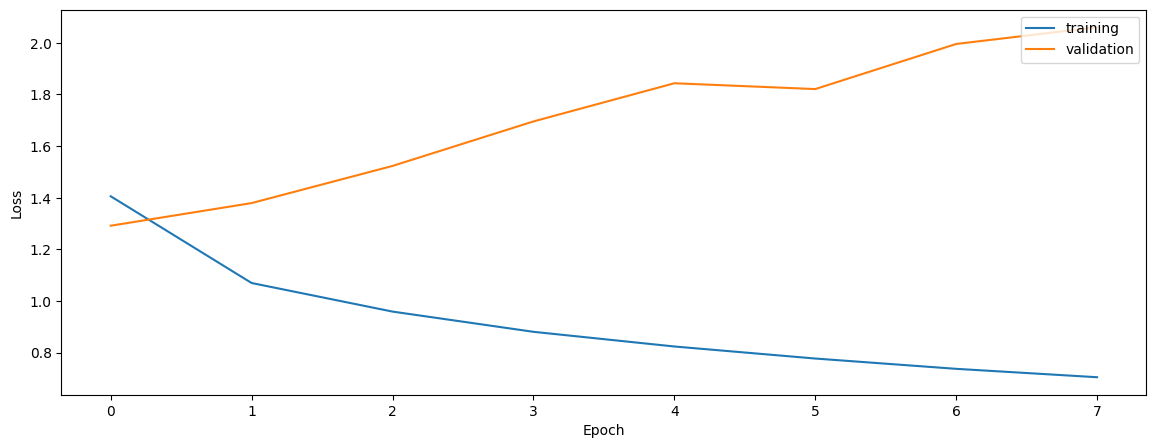

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5382603298457174
0.4807704106675393
0.4592803729122082


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5291739348542372
0.5057294233612617
0.49124983459044597


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.533106041491018
0.4980602491294492
0.4987682025514062


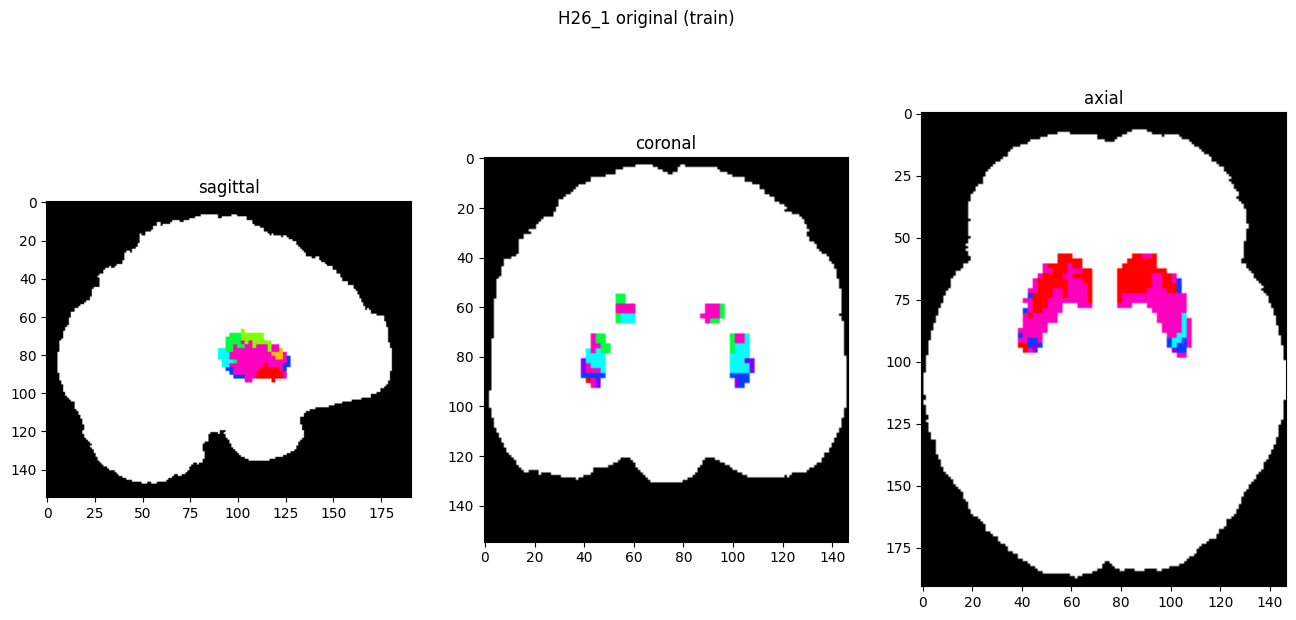

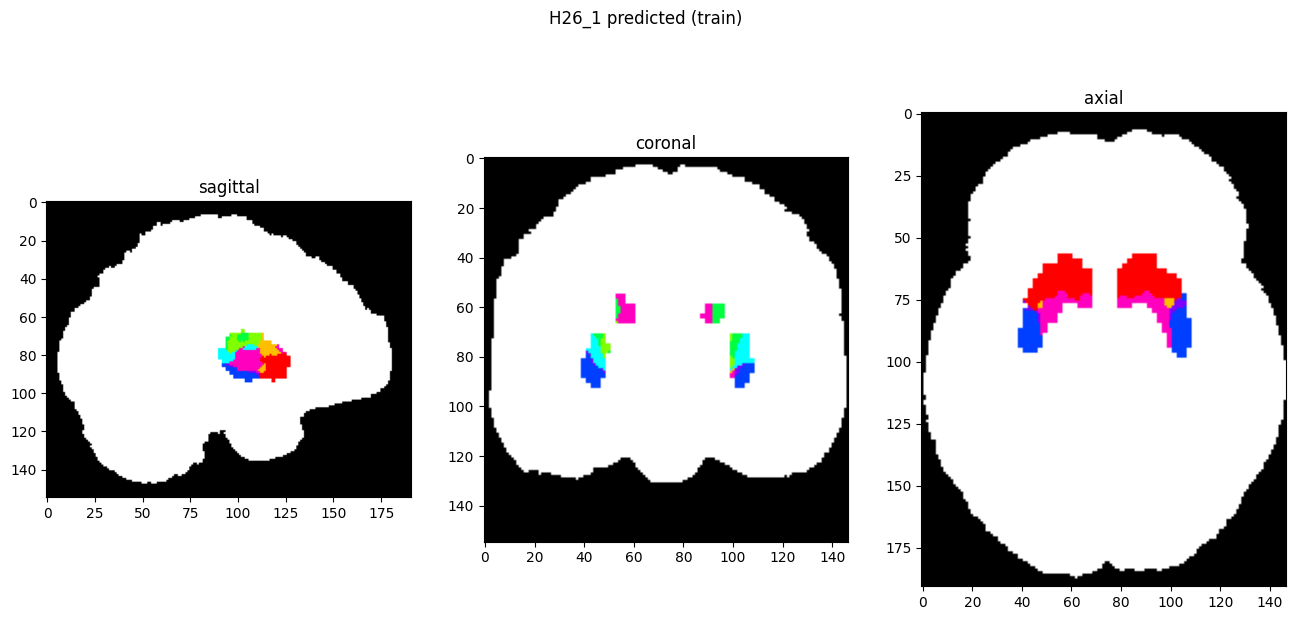

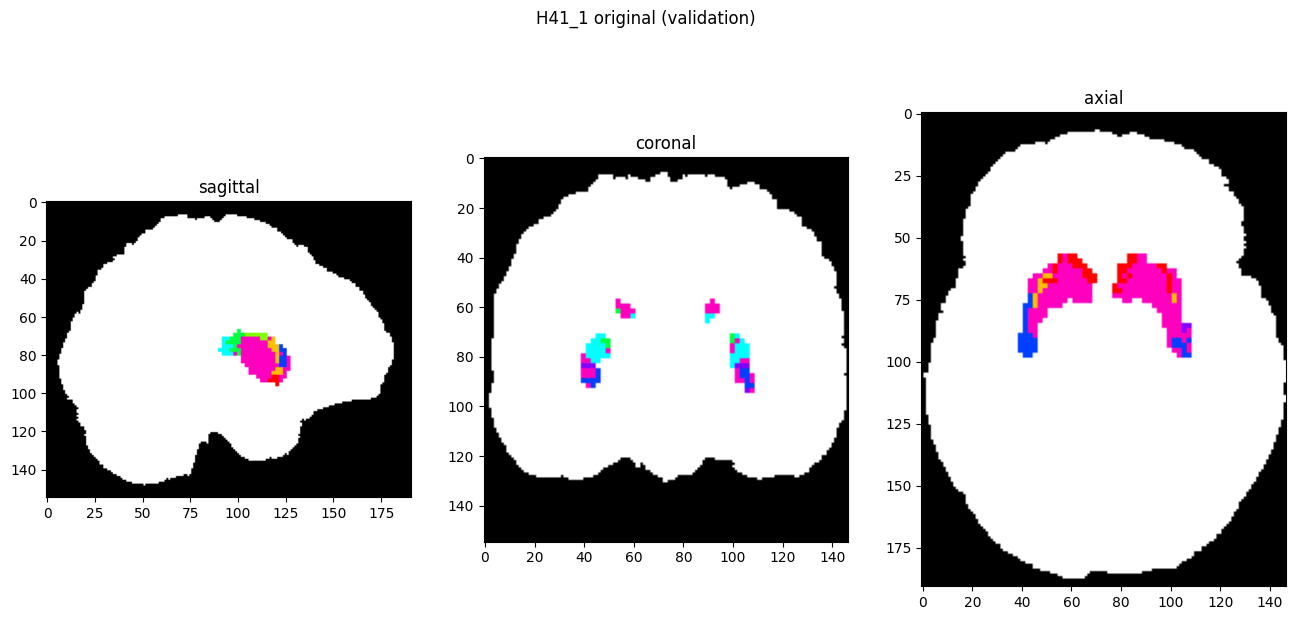

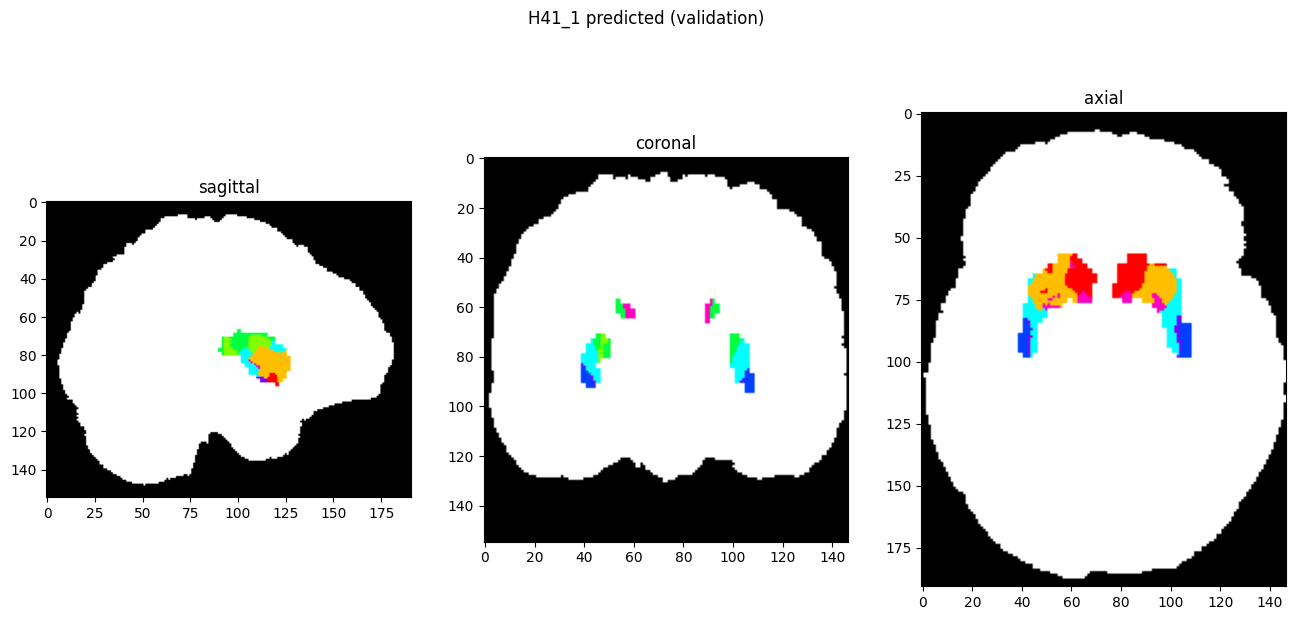

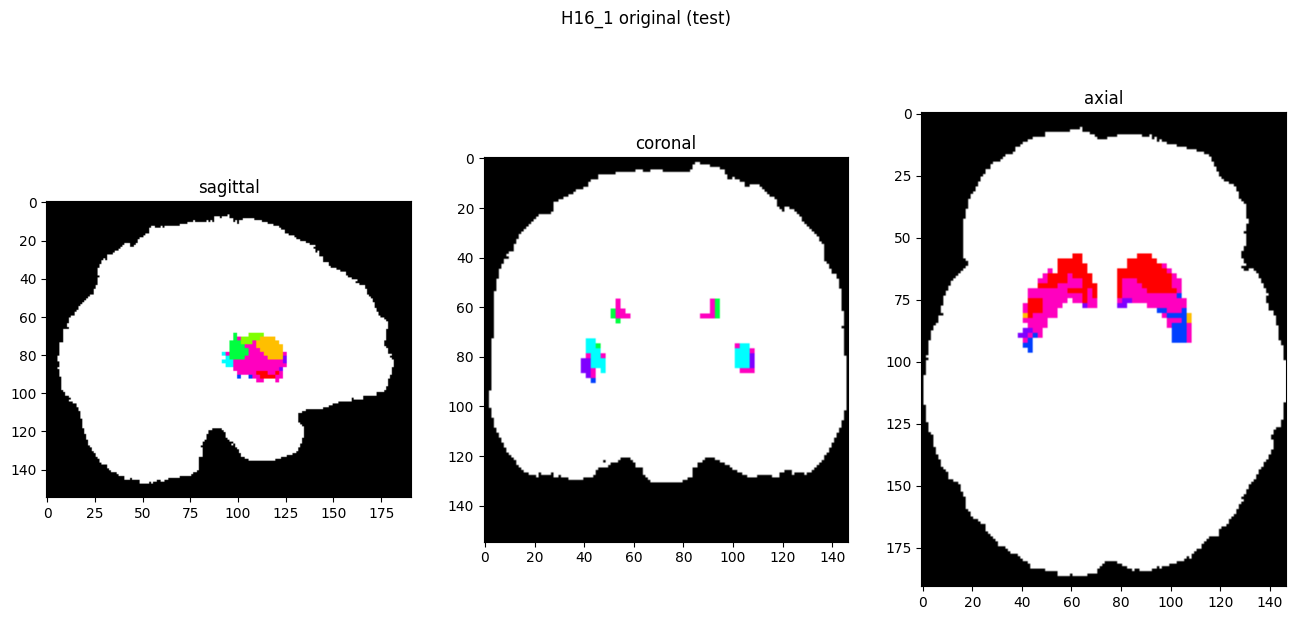

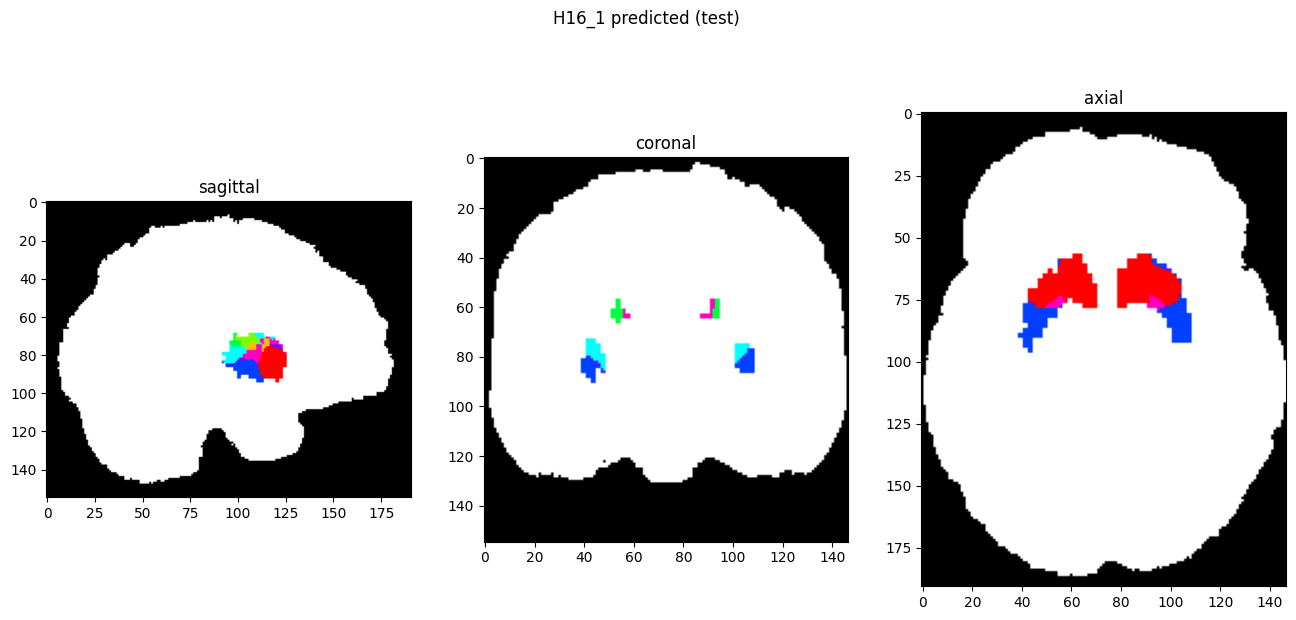

In [10]:
showResults(model, gen, threshold=0)